In [1]:
!nvidia-smi

Mon Dec  5 23:57:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   38C    P0    62W / 300W |  23299MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  1.8 ; cuda:  1.8.0


In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import cv2
import json
from tqdm.notebook import tqdm
import subprocess
import time
from pathlib import Path


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.structures import Boxes, BoxMode 
import pycocotools.mask as mask_util


# For reading annotations file
from pycocotools.coco import COCO

# utilities
from pprint import pprint # For beautiful print!
from collections import OrderedDict
import os 

# For data visualisation
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
# from google.colab.patches import cv2_imshow

In [4]:
os.chdir('..')
os.getcwd()

'/home/cuai5th/CUAI_2022/SangwuPark/FoodDetection'

In [5]:
# For reading annotations file
import json
from pycocotools.coco import COCO

# Reading annotations.json
TRAIN_ANNOTATIONS_PATH = "data/train/annotations.json"
TRAIN_IMAGE_DIRECTIORY = "data/train/images/"

VAL_ANNOTATIONS_PATH = "data/val/annotations.json"
VAL_IMAGE_DIRECTIORY = "data/val/images/"

train_coco = COCO(TRAIN_ANNOTATIONS_PATH)

loading annotations into memory...
Done (t=3.94s)
creating index...
index created!


In [6]:
val_coco = COCO(VAL_ANNOTATIONS_PATH)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [7]:
# Reading the annotation files
with open(TRAIN_ANNOTATIONS_PATH) as f:
  train_annotations_data = json.load(f)

with open(VAL_ANNOTATIONS_PATH) as f:
  val_annotations_data = json.load(f)
train_annotations_data['annotations'][0]

{'id': 184123,
 'image_id': 131072,
 'category_id': 101246,
 'segmentation': [[169.0,
   379.5,
   130.0,
   374.5,
   112.0,
   363.5,
   94.5,
   340.0,
   61.5,
   213.0,
   61.5,
   188.0,
   70.5,
   168.0,
   87.0,
   152.5,
   103.0,
   143.5,
   123.0,
   139.5,
   185.0,
   118.5,
   226.0,
   90.5,
   249.0,
   87.5,
   309.0,
   88.5,
   339.0,
   110.5,
   350.5,
   125.00000000000001,
   354.5,
   155.0,
   382.5,
   231.0,
   383.5,
   277.0,
   360.0,
   303.5,
   327.0,
   331.5,
   308.0,
   343.5,
   216.0,
   373.5]],
 'area': 71393.0,
 'bbox': [61.5, 61.5, 318.0, 322.0],
 'iscrowd': 0}

In [8]:
# Reading all classes
category_ids = train_coco.loadCats(train_coco.getCatIds())
category_names = [_["name_readable"] for _ in category_ids]

print("## Categories\n-", "\n- ".join(category_names))

## Categories
- Beetroot, steamed, without addition of salt
- bread_wholemeal
- jam
- water
- bread
- banana
- soft_cheese
- ham_raw
- hard_cheese
- cottage_cheese
- coffee
- fruit_mixed
- pancake
- tea
- salmon_smoked
- avocado
- spring_onion_scallion
- ristretto_with_caffeine
- ham_n_s
- egg
- bacon
- chips_french_fries
- juice_apple
- chicken
- tomato
- broccoli
- shrimp_prawn
- carrot
- chickpeas
- french_salad_dressing
- pasta_hornli_ch
- sauce_cream
- pasta_n_s
- tomato_sauce
- cheese_n_s
- pear
- cashew_nut
- almonds
- lentil_n_s
- mixed_vegetables
- peanut_butter
- apple
- blueberries
- cucumber
- yogurt
- butter
- mayonnaise
- soup
- wine_red
- wine_white
- green_bean_steamed_without_addition_of_salt
- sausage
- pizza_margherita_baked
- salami_ch
- mushroom
- tart_n_s
- rice
- white_coffee
- sunflower_seeds
- bell_pepper_red_raw
- zucchini
- asparagus
- tartar_sauce
- lye_pretzel_soft
- cucumber_pickled_ch
- curry_vegetarian
- soup_of_lentils_dahl_dhal
- salmon
- salt_cake_ch_

In [9]:
dict_addres = val_annotations_data['images'][748]
plt.imread(VAL_IMAGE_DIRECTIORY+dict_addres['file_name']).shape[:2], (dict_addres['height'], dict_addres['width'])


((480, 480), (480, 480))

In [10]:
train_annotations_path = 'data/train/new_ann.json'
train_images_path = 'data/train/images'

val_annotations_path = 'data/val/new_ann.json'
val_images_path = 'data/val/images'

In [11]:
register_coco_instances("training_dataset", {},train_annotations_path, train_images_path)
register_coco_instances("validation_dataset", {},val_annotations_path, VAL_IMAGE_DIRECTIORY)

In [12]:
# MODEL_ARCH = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
MODEL_ARCH = "COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml"

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL_ARCH))

cfg.DATASETS.TRAIN = ("training_dataset",)
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL_ARCH)

epoch is MAX_ITER * BATCH_SIZE / TOTAL_NUM_IMAGES

In [13]:
# No. of Batchs
cfg.SOLVER.IMS_PER_BATCH = 2     #for 16 GB GPU, reduce it to 2 for 12 GB GPU if you face CUDA memory error

# Learning Rate: 
cfg.SOLVER.BASE_LR = 0.0025

# No of Interations
cfg.SOLVER.MAX_ITER = 100000

# Options: WarmupMultiStepLR, WarmupCosineLR.
# See detectron2/solver/build.py for definition.
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"

# mini batch size would be (SOLVER.IMS_PER_BATCH) * (ROI_HEADS.BATCH_SIZE_PER_IMAGE).


#save every 1000 steps
cfg.SOLVER.CHECKPOINT_PERIOD = 1000

# Images per batch (Batch Size) 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256

# No of Categories(Classes) present
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 498

# model freeze 
cfg.MODEL.BACKBONE.FREEZE_AT = 6


#Output directory
#### NOTE: You can also download pre-trained folder from Google Drive and upload in your drive; links are shared in above cell.
# cfg.OUTPUT_DIR = "/content/drive/MyDrive/logs_detectron2_x101"
cfg.OUTPUT_DIR = "R101_C4/freeze6"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [14]:
#set if to true if you want to resume training
RESUME = True
trainer = DefaultTrainer(cfg) 

if RESUME:
  trainer.resume_or_load(resume=True)
else:
  trainer.resume_or_load(resume=False)


[12/05 23:57:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

[12/05 23:57:20 d2.data.datasets.coco]: Loading data/train/new_ann.json takes 3.90 seconds.
WARNING [12/05 23:57:20 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/05 23:57:21 d2.data.datasets.coco]: Loaded 54392 images in COCO format from data/train/new_ann.json
[12/05 23:57:21 d2.data.build]: Removed 0 images with no usable annotations. 54392 images left.
[12/05 23:57:24 d2.data.build]: Distribution of instances among all 323 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| beetroot-st.. | 283          | green_bean_.. | 98           | watermelon_.. | 130          |
| tuna_in_oil.. | 59           | sweet_potato  | 286          | country_fries | 99           |
| potato_gnoc.. | 122          | chips_frenc.. | 482          |   rosti_n_s   | 126          |
| vegetable

[12/05 23:57:24 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[12/05 23:57:24 d2.data.build]: Using training sampler TrainingSampler
[12/05 23:57:24 d2.data.common]: Serializing 54392 elements to byte tensors and concatenating them all ...
[12/05 23:57:25 d2.data.common]: Serialized dataset takes 137.40 MiB
WARNING [12/05 23:57:25 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.
[12/05 23:57:25 d2.engine.hooks]: Loading scheduler from state_dict ...


In [15]:
trainer.train()


[12/05 01:38:44 d2.engine.train_loop]: Starting training from iteration 27000
[12/05 01:38:50 d2.utils.events]:  eta: 5:06:42  iter: 27019  total_loss: 1.376  loss_cls: 0.5115  loss_box_reg: 0.4499  loss_mask: 0.1907  loss_rpn_cls: 0.06618  loss_rpn_loc: 0.0685  time: 0.2509  data_time: 0.0163  lr: 0.0025  max_mem: 2395M
[12/05 01:38:55 d2.utils.events]:  eta: 5:06:54  iter: 27039  total_loss: 1.269  loss_cls: 0.452  loss_box_reg: 0.3722  loss_mask: 0.2025  loss_rpn_cls: 0.04242  loss_rpn_loc: 0.07756  time: 0.2527  data_time: 0.0044  lr: 0.0025  max_mem: 2395M
[12/05 01:39:00 d2.utils.events]:  eta: 5:06:49  iter: 27059  total_loss: 1.385  loss_cls: 0.5343  loss_box_reg: 0.3881  loss_mask: 0.1772  loss_rpn_cls: 0.05455  loss_rpn_loc: 0.08867  time: 0.2529  data_time: 0.0043  lr: 0.0025  max_mem: 2395M
[12/05 01:39:05 d2.utils.events]:  eta: 5:06:28  iter: 27079  total_loss: 1.209  loss_cls: 0.4452  loss_box_reg: 0.3658  loss_mask: 0.2393  loss_rpn_cls: 0.0458  loss_rpn_loc: 0.07327  t

[12/05 01:41:43 d2.utils.events]:  eta: 5:03:54  iter: 27699  total_loss: 1.069  loss_cls: 0.459  loss_box_reg: 0.3024  loss_mask: 0.2257  loss_rpn_cls: 0.04519  loss_rpn_loc: 0.08276  time: 0.2541  data_time: 0.0038  lr: 0.0025  max_mem: 2431M
[12/05 01:41:48 d2.utils.events]:  eta: 5:03:46  iter: 27719  total_loss: 1.121  loss_cls: 0.4684  loss_box_reg: 0.3523  loss_mask: 0.2118  loss_rpn_cls: 0.04777  loss_rpn_loc: 0.09375  time: 0.2540  data_time: 0.0040  lr: 0.0025  max_mem: 2431M
[12/05 01:41:53 d2.utils.events]:  eta: 5:03:36  iter: 27739  total_loss: 0.8872  loss_cls: 0.3276  loss_box_reg: 0.2945  loss_mask: 0.1542  loss_rpn_cls: 0.05357  loss_rpn_loc: 0.06949  time: 0.2539  data_time: 0.0041  lr: 0.0025  max_mem: 2431M
[12/05 01:41:58 d2.utils.events]:  eta: 5:03:29  iter: 27759  total_loss: 0.9209  loss_cls: 0.379  loss_box_reg: 0.2897  loss_mask: 0.2176  loss_rpn_cls: 0.05956  loss_rpn_loc: 0.06475  time: 0.2539  data_time: 0.0047  lr: 0.0025  max_mem: 2431M
[12/05 01:42:03 

[12/05 01:44:37 d2.utils.events]:  eta: 5:01:00  iter: 28379  total_loss: 1.256  loss_cls: 0.5111  loss_box_reg: 0.3692  loss_mask: 0.2657  loss_rpn_cls: 0.04795  loss_rpn_loc: 0.0696  time: 0.2540  data_time: 0.0098  lr: 0.0025  max_mem: 2434M
[12/05 01:44:42 d2.utils.events]:  eta: 5:00:55  iter: 28399  total_loss: 1.13  loss_cls: 0.4304  loss_box_reg: 0.3364  loss_mask: 0.206  loss_rpn_cls: 0.05007  loss_rpn_loc: 0.08772  time: 0.2540  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 01:44:47 d2.utils.events]:  eta: 5:00:46  iter: 28419  total_loss: 1.243  loss_cls: 0.5121  loss_box_reg: 0.3298  loss_mask: 0.1893  loss_rpn_cls: 0.05667  loss_rpn_loc: 0.07732  time: 0.2540  data_time: 0.0097  lr: 0.0025  max_mem: 2434M
[12/05 01:44:52 d2.utils.events]:  eta: 5:00:38  iter: 28439  total_loss: 1.274  loss_cls: 0.4924  loss_box_reg: 0.3285  loss_mask: 0.2216  loss_rpn_cls: 0.04183  loss_rpn_loc: 0.08207  time: 0.2539  data_time: 0.0037  lr: 0.0025  max_mem: 2434M
[12/05 01:44:57 d2.

[12/05 01:47:30 d2.utils.events]:  eta: 4:58:05  iter: 29059  total_loss: 1.16  loss_cls: 0.5318  loss_box_reg: 0.3123  loss_mask: 0.1837  loss_rpn_cls: 0.03509  loss_rpn_loc: 0.08181  time: 0.2540  data_time: 0.0047  lr: 0.0025  max_mem: 2434M
[12/05 01:47:35 d2.utils.events]:  eta: 4:58:02  iter: 29079  total_loss: 1.124  loss_cls: 0.4701  loss_box_reg: 0.331  loss_mask: 0.2371  loss_rpn_cls: 0.0451  loss_rpn_loc: 0.06669  time: 0.2541  data_time: 0.0208  lr: 0.0025  max_mem: 2434M
[12/05 01:47:40 d2.utils.events]:  eta: 4:58:08  iter: 29099  total_loss: 1.396  loss_cls: 0.6187  loss_box_reg: 0.3733  loss_mask: 0.1882  loss_rpn_cls: 0.06412  loss_rpn_loc: 0.08768  time: 0.2542  data_time: 0.0047  lr: 0.0025  max_mem: 2434M
[12/05 01:47:46 d2.utils.events]:  eta: 4:58:05  iter: 29119  total_loss: 1.023  loss_cls: 0.352  loss_box_reg: 0.3139  loss_mask: 0.1628  loss_rpn_cls: 0.04467  loss_rpn_loc: 0.08062  time: 0.2543  data_time: 0.0163  lr: 0.0025  max_mem: 2434M
[12/05 01:47:51 d2.u

[12/05 01:50:24 d2.utils.events]:  eta: 4:56:39  iter: 29739  total_loss: 1.239  loss_cls: 0.4634  loss_box_reg: 0.3329  loss_mask: 0.2657  loss_rpn_cls: 0.05352  loss_rpn_loc: 0.07129  time: 0.2544  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 01:50:29 d2.utils.events]:  eta: 4:56:30  iter: 29759  total_loss: 1.147  loss_cls: 0.4577  loss_box_reg: 0.3391  loss_mask: 0.1917  loss_rpn_cls: 0.06462  loss_rpn_loc: 0.05551  time: 0.2544  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 01:50:34 d2.utils.events]:  eta: 4:56:30  iter: 29779  total_loss: 1.507  loss_cls: 0.6464  loss_box_reg: 0.3934  loss_mask: 0.1897  loss_rpn_cls: 0.05486  loss_rpn_loc: 0.08764  time: 0.2544  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 01:50:39 d2.utils.events]:  eta: 4:56:28  iter: 29799  total_loss: 1.036  loss_cls: 0.4658  loss_box_reg: 0.3395  loss_mask: 0.1825  loss_rpn_cls: 0.05313  loss_rpn_loc: 0.08884  time: 0.2544  data_time: 0.0049  lr: 0.0025  max_mem: 2434M
[12/05 01:50:44 

[12/05 01:53:19 d2.utils.events]:  eta: 4:53:47  iter: 30419  total_loss: 1.106  loss_cls: 0.4419  loss_box_reg: 0.2926  loss_mask: 0.2031  loss_rpn_cls: 0.04334  loss_rpn_loc: 0.08349  time: 0.2547  data_time: 0.0047  lr: 0.0025  max_mem: 2434M
[12/05 01:53:24 d2.utils.events]:  eta: 4:53:41  iter: 30439  total_loss: 1.274  loss_cls: 0.5079  loss_box_reg: 0.3532  loss_mask: 0.2559  loss_rpn_cls: 0.04993  loss_rpn_loc: 0.08802  time: 0.2546  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 01:53:29 d2.utils.events]:  eta: 4:53:31  iter: 30459  total_loss: 1.303  loss_cls: 0.4092  loss_box_reg: 0.3304  loss_mask: 0.1676  loss_rpn_cls: 0.04869  loss_rpn_loc: 0.09365  time: 0.2546  data_time: 0.0037  lr: 0.0025  max_mem: 2434M
[12/05 01:53:34 d2.utils.events]:  eta: 4:53:23  iter: 30479  total_loss: 1.126  loss_cls: 0.4771  loss_box_reg: 0.32  loss_mask: 0.2049  loss_rpn_cls: 0.04733  loss_rpn_loc: 0.06541  time: 0.2546  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 01:53:39 d2

[12/05 01:56:14 d2.utils.events]:  eta: 4:50:43  iter: 31099  total_loss: 1.158  loss_cls: 0.401  loss_box_reg: 0.3398  loss_mask: 0.1913  loss_rpn_cls: 0.04682  loss_rpn_loc: 0.06238  time: 0.2549  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 01:56:19 d2.utils.events]:  eta: 4:50:37  iter: 31119  total_loss: 1.12  loss_cls: 0.414  loss_box_reg: 0.3397  loss_mask: 0.1783  loss_rpn_cls: 0.0402  loss_rpn_loc: 0.07402  time: 0.2549  data_time: 0.0052  lr: 0.0025  max_mem: 2434M
[12/05 01:56:24 d2.utils.events]:  eta: 4:50:32  iter: 31139  total_loss: 1.028  loss_cls: 0.3612  loss_box_reg: 0.2947  loss_mask: 0.2097  loss_rpn_cls: 0.03848  loss_rpn_loc: 0.07029  time: 0.2549  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 01:56:29 d2.utils.events]:  eta: 4:50:26  iter: 31159  total_loss: 1.168  loss_cls: 0.3211  loss_box_reg: 0.3448  loss_mask: 0.2195  loss_rpn_cls: 0.05721  loss_rpn_loc: 0.08079  time: 0.2549  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 01:56:34 d2.u

[12/05 01:59:06 d2.utils.events]:  eta: 4:47:19  iter: 31779  total_loss: 1.054  loss_cls: 0.3758  loss_box_reg: 0.3283  loss_mask: 0.211  loss_rpn_cls: 0.03658  loss_rpn_loc: 0.08885  time: 0.2547  data_time: 0.0047  lr: 0.0025  max_mem: 2434M
[12/05 01:59:11 d2.utils.events]:  eta: 4:47:11  iter: 31799  total_loss: 1.431  loss_cls: 0.5724  loss_box_reg: 0.3554  loss_mask: 0.2536  loss_rpn_cls: 0.03986  loss_rpn_loc: 0.1024  time: 0.2547  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 01:59:16 d2.utils.events]:  eta: 4:47:03  iter: 31819  total_loss: 1.265  loss_cls: 0.5691  loss_box_reg: 0.3524  loss_mask: 0.2262  loss_rpn_cls: 0.05275  loss_rpn_loc: 0.07829  time: 0.2547  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 01:59:22 d2.utils.events]:  eta: 4:46:57  iter: 31839  total_loss: 1.059  loss_cls: 0.4699  loss_box_reg: 0.3121  loss_mask: 0.1864  loss_rpn_cls: 0.03397  loss_rpn_loc: 0.08355  time: 0.2547  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 01:59:27 d2

[12/05 02:02:00 d2.utils.events]:  eta: 4:44:18  iter: 32459  total_loss: 1.223  loss_cls: 0.4905  loss_box_reg: 0.3936  loss_mask: 0.1887  loss_rpn_cls: 0.05436  loss_rpn_loc: 0.05779  time: 0.2547  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 02:02:05 d2.utils.events]:  eta: 4:44:13  iter: 32479  total_loss: 1.103  loss_cls: 0.4126  loss_box_reg: 0.2924  loss_mask: 0.2265  loss_rpn_cls: 0.04267  loss_rpn_loc: 0.08085  time: 0.2547  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 02:02:10 d2.utils.events]:  eta: 4:44:00  iter: 32499  total_loss: 1.007  loss_cls: 0.414  loss_box_reg: 0.3238  loss_mask: 0.1775  loss_rpn_cls: 0.04002  loss_rpn_loc: 0.08403  time: 0.2547  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 02:02:15 d2.utils.events]:  eta: 4:43:58  iter: 32519  total_loss: 1.479  loss_cls: 0.5213  loss_box_reg: 0.4411  loss_mask: 0.2232  loss_rpn_cls: 0.05219  loss_rpn_loc: 0.08242  time: 0.2547  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 02:02:20 d

[12/05 02:04:54 d2.utils.events]:  eta: 4:41:21  iter: 33139  total_loss: 1.419  loss_cls: 0.4912  loss_box_reg: 0.4162  loss_mask: 0.2217  loss_rpn_cls: 0.05805  loss_rpn_loc: 0.1016  time: 0.2548  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 02:04:59 d2.utils.events]:  eta: 4:41:18  iter: 33159  total_loss: 1.263  loss_cls: 0.5175  loss_box_reg: 0.3674  loss_mask: 0.2274  loss_rpn_cls: 0.06264  loss_rpn_loc: 0.0902  time: 0.2547  data_time: 0.0047  lr: 0.0025  max_mem: 2434M
[12/05 02:05:04 d2.utils.events]:  eta: 4:41:16  iter: 33179  total_loss: 1.153  loss_cls: 0.4598  loss_box_reg: 0.3476  loss_mask: 0.1876  loss_rpn_cls: 0.06031  loss_rpn_loc: 0.07473  time: 0.2547  data_time: 0.0045  lr: 0.0025  max_mem: 2434M
[12/05 02:05:09 d2.utils.events]:  eta: 4:41:11  iter: 33199  total_loss: 1.498  loss_cls: 0.584  loss_box_reg: 0.4013  loss_mask: 0.2873  loss_rpn_cls: 0.05895  loss_rpn_loc: 0.07753  time: 0.2548  data_time: 0.0046  lr: 0.0025  max_mem: 2434M
[12/05 02:05:15 d2.

[12/05 02:07:47 d2.utils.events]:  eta: 4:39:05  iter: 33819  total_loss: 1.003  loss_cls: 0.4235  loss_box_reg: 0.3064  loss_mask: 0.1659  loss_rpn_cls: 0.05064  loss_rpn_loc: 0.07332  time: 0.2547  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 02:07:52 d2.utils.events]:  eta: 4:39:12  iter: 33839  total_loss: 1.4  loss_cls: 0.4639  loss_box_reg: 0.3628  loss_mask: 0.2744  loss_rpn_cls: 0.04973  loss_rpn_loc: 0.08197  time: 0.2547  data_time: 0.0047  lr: 0.0025  max_mem: 2434M
[12/05 02:07:57 d2.utils.events]:  eta: 4:39:03  iter: 33859  total_loss: 1.437  loss_cls: 0.5559  loss_box_reg: 0.4303  loss_mask: 0.3161  loss_rpn_cls: 0.03866  loss_rpn_loc: 0.1171  time: 0.2547  data_time: 0.0037  lr: 0.0025  max_mem: 2434M
[12/05 02:08:02 d2.utils.events]:  eta: 4:38:54  iter: 33879  total_loss: 1.144  loss_cls: 0.3772  loss_box_reg: 0.3174  loss_mask: 0.2818  loss_rpn_cls: 0.0462  loss_rpn_loc: 0.08176  time: 0.2547  data_time: 0.0057  lr: 0.0025  max_mem: 2434M
[12/05 02:08:08 d2.u

[12/05 02:10:41 d2.utils.events]:  eta: 4:36:42  iter: 34499  total_loss: 1.116  loss_cls: 0.3622  loss_box_reg: 0.3605  loss_mask: 0.1993  loss_rpn_cls: 0.05214  loss_rpn_loc: 0.07207  time: 0.2546  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 02:10:46 d2.utils.events]:  eta: 4:36:38  iter: 34519  total_loss: 1.338  loss_cls: 0.4544  loss_box_reg: 0.3665  loss_mask: 0.2219  loss_rpn_cls: 0.04734  loss_rpn_loc: 0.1023  time: 0.2546  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 02:10:51 d2.utils.events]:  eta: 4:36:37  iter: 34539  total_loss: 1.029  loss_cls: 0.3952  loss_box_reg: 0.2998  loss_mask: 0.1855  loss_rpn_cls: 0.04321  loss_rpn_loc: 0.1122  time: 0.2546  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 02:10:56 d2.utils.events]:  eta: 4:36:33  iter: 34559  total_loss: 1.187  loss_cls: 0.4077  loss_box_reg: 0.3756  loss_mask: 0.1684  loss_rpn_cls: 0.03673  loss_rpn_loc: 0.06245  time: 0.2546  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 02:11:01 d2

[12/05 02:13:35 d2.utils.events]:  eta: 4:33:52  iter: 35179  total_loss: 0.9722  loss_cls: 0.3622  loss_box_reg: 0.3061  loss_mask: 0.1764  loss_rpn_cls: 0.05699  loss_rpn_loc: 0.08746  time: 0.2547  data_time: 0.0037  lr: 0.0025  max_mem: 2434M
[12/05 02:13:40 d2.utils.events]:  eta: 4:33:39  iter: 35199  total_loss: 1.17  loss_cls: 0.4184  loss_box_reg: 0.3686  loss_mask: 0.2842  loss_rpn_cls: 0.05017  loss_rpn_loc: 0.06886  time: 0.2547  data_time: 0.0048  lr: 0.0025  max_mem: 2434M
[12/05 02:13:45 d2.utils.events]:  eta: 4:33:31  iter: 35219  total_loss: 1.088  loss_cls: 0.4021  loss_box_reg: 0.3029  loss_mask: 0.193  loss_rpn_cls: 0.04953  loss_rpn_loc: 0.07716  time: 0.2547  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 02:13:50 d2.utils.events]:  eta: 4:33:25  iter: 35239  total_loss: 0.9904  loss_cls: 0.3979  loss_box_reg: 0.2847  loss_mask: 0.2175  loss_rpn_cls: 0.04397  loss_rpn_loc: 0.09773  time: 0.2547  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 02:13:55 

[12/05 02:16:28 d2.utils.events]:  eta: 4:30:48  iter: 35859  total_loss: 1.042  loss_cls: 0.3709  loss_box_reg: 0.2995  loss_mask: 0.2533  loss_rpn_cls: 0.04417  loss_rpn_loc: 0.086  time: 0.2547  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 02:16:33 d2.utils.events]:  eta: 4:30:47  iter: 35879  total_loss: 1.363  loss_cls: 0.5519  loss_box_reg: 0.3993  loss_mask: 0.2303  loss_rpn_cls: 0.05412  loss_rpn_loc: 0.08524  time: 0.2547  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 02:16:38 d2.utils.events]:  eta: 4:30:42  iter: 35899  total_loss: 1.325  loss_cls: 0.5262  loss_box_reg: 0.3733  loss_mask: 0.2415  loss_rpn_cls: 0.05226  loss_rpn_loc: 0.09722  time: 0.2547  data_time: 0.0054  lr: 0.0025  max_mem: 2434M
[12/05 02:16:43 d2.utils.events]:  eta: 4:30:37  iter: 35919  total_loss: 0.8222  loss_cls: 0.3293  loss_box_reg: 0.2603  loss_mask: 0.1755  loss_rpn_cls: 0.04437  loss_rpn_loc: 0.06182  time: 0.2547  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 02:16:49 d

[12/05 02:19:22 d2.utils.events]:  eta: 4:27:35  iter: 36539  total_loss: 1.148  loss_cls: 0.4255  loss_box_reg: 0.3437  loss_mask: 0.2429  loss_rpn_cls: 0.06278  loss_rpn_loc: 0.09102  time: 0.2547  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 02:19:27 d2.utils.events]:  eta: 4:27:23  iter: 36559  total_loss: 1.084  loss_cls: 0.4616  loss_box_reg: 0.3118  loss_mask: 0.163  loss_rpn_cls: 0.06537  loss_rpn_loc: 0.06789  time: 0.2547  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 02:19:32 d2.utils.events]:  eta: 4:27:23  iter: 36579  total_loss: 1.236  loss_cls: 0.4718  loss_box_reg: 0.3791  loss_mask: 0.195  loss_rpn_cls: 0.05686  loss_rpn_loc: 0.07106  time: 0.2547  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 02:19:37 d2.utils.events]:  eta: 4:27:13  iter: 36599  total_loss: 1.128  loss_cls: 0.5133  loss_box_reg: 0.3166  loss_mask: 0.2356  loss_rpn_cls: 0.04914  loss_rpn_loc: 0.1039  time: 0.2547  data_time: 0.0080  lr: 0.0025  max_mem: 2434M
[12/05 02:19:42 d2.

[12/05 02:22:16 d2.utils.events]:  eta: 4:25:17  iter: 37219  total_loss: 1.119  loss_cls: 0.477  loss_box_reg: 0.3652  loss_mask: 0.1973  loss_rpn_cls: 0.04184  loss_rpn_loc: 0.07301  time: 0.2547  data_time: 0.0049  lr: 0.0025  max_mem: 2434M
[12/05 02:22:21 d2.utils.events]:  eta: 4:25:13  iter: 37239  total_loss: 1.366  loss_cls: 0.56  loss_box_reg: 0.3243  loss_mask: 0.2586  loss_rpn_cls: 0.06186  loss_rpn_loc: 0.07904  time: 0.2547  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 02:22:26 d2.utils.events]:  eta: 4:25:08  iter: 37259  total_loss: 1.204  loss_cls: 0.5259  loss_box_reg: 0.3115  loss_mask: 0.2524  loss_rpn_cls: 0.03752  loss_rpn_loc: 0.09283  time: 0.2547  data_time: 0.0048  lr: 0.0025  max_mem: 2434M
[12/05 02:22:31 d2.utils.events]:  eta: 4:25:00  iter: 37279  total_loss: 1.552  loss_cls: 0.6294  loss_box_reg: 0.4524  loss_mask: 0.2864  loss_rpn_cls: 0.05941  loss_rpn_loc: 0.09724  time: 0.2547  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 02:22:36 d2.

[12/05 02:25:09 d2.utils.events]:  eta: 4:22:06  iter: 37899  total_loss: 1.537  loss_cls: 0.6443  loss_box_reg: 0.4527  loss_mask: 0.2278  loss_rpn_cls: 0.0848  loss_rpn_loc: 0.08915  time: 0.2547  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 02:25:14 d2.utils.events]:  eta: 4:21:58  iter: 37919  total_loss: 1.171  loss_cls: 0.4684  loss_box_reg: 0.3741  loss_mask: 0.2508  loss_rpn_cls: 0.0358  loss_rpn_loc: 0.06717  time: 0.2547  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 02:25:19 d2.utils.events]:  eta: 4:21:53  iter: 37939  total_loss: 1.258  loss_cls: 0.4152  loss_box_reg: 0.3078  loss_mask: 0.2578  loss_rpn_cls: 0.0296  loss_rpn_loc: 0.07913  time: 0.2547  data_time: 0.0056  lr: 0.0025  max_mem: 2434M
[12/05 02:25:24 d2.utils.events]:  eta: 4:21:47  iter: 37959  total_loss: 1.436  loss_cls: 0.458  loss_box_reg: 0.35  loss_mask: 0.2506  loss_rpn_cls: 0.07312  loss_rpn_loc: 0.1085  time: 0.2547  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 02:25:30 d2.util

[12/05 02:28:04 d2.utils.events]:  eta: 4:19:12  iter: 38579  total_loss: 1.054  loss_cls: 0.4032  loss_box_reg: 0.3493  loss_mask: 0.2105  loss_rpn_cls: 0.04048  loss_rpn_loc: 0.09422  time: 0.2547  data_time: 0.0045  lr: 0.0025  max_mem: 2434M
[12/05 02:28:09 d2.utils.events]:  eta: 4:19:08  iter: 38599  total_loss: 1.116  loss_cls: 0.383  loss_box_reg: 0.3457  loss_mask: 0.2106  loss_rpn_cls: 0.03843  loss_rpn_loc: 0.07455  time: 0.2547  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 02:28:14 d2.utils.events]:  eta: 4:19:03  iter: 38619  total_loss: 0.9448  loss_cls: 0.3613  loss_box_reg: 0.2866  loss_mask: 0.2334  loss_rpn_cls: 0.04026  loss_rpn_loc: 0.0814  time: 0.2547  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 02:28:19 d2.utils.events]:  eta: 4:19:10  iter: 38639  total_loss: 1.602  loss_cls: 0.7527  loss_box_reg: 0.4371  loss_mask: 0.3137  loss_rpn_cls: 0.05268  loss_rpn_loc: 0.1169  time: 0.2547  data_time: 0.0046  lr: 0.0025  max_mem: 2434M
[12/05 02:28:24 d2

[12/05 02:30:58 d2.utils.events]:  eta: 4:16:49  iter: 39259  total_loss: 0.9996  loss_cls: 0.3896  loss_box_reg: 0.3002  loss_mask: 0.2043  loss_rpn_cls: 0.0488  loss_rpn_loc: 0.06917  time: 0.2548  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 02:31:03 d2.utils.events]:  eta: 4:16:37  iter: 39279  total_loss: 1.026  loss_cls: 0.3444  loss_box_reg: 0.3494  loss_mask: 0.1876  loss_rpn_cls: 0.05416  loss_rpn_loc: 0.0731  time: 0.2548  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 02:31:08 d2.utils.events]:  eta: 4:16:32  iter: 39299  total_loss: 1.166  loss_cls: 0.4789  loss_box_reg: 0.3927  loss_mask: 0.1967  loss_rpn_cls: 0.04374  loss_rpn_loc: 0.07571  time: 0.2548  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 02:31:13 d2.utils.events]:  eta: 4:16:34  iter: 39319  total_loss: 1.1  loss_cls: 0.4489  loss_box_reg: 0.3295  loss_mask: 0.1869  loss_rpn_cls: 0.04693  loss_rpn_loc: 0.08149  time: 0.2548  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 02:31:19 d2.

[12/05 02:33:51 d2.utils.events]:  eta: 4:13:06  iter: 39939  total_loss: 1.287  loss_cls: 0.4981  loss_box_reg: 0.3708  loss_mask: 0.241  loss_rpn_cls: 0.06489  loss_rpn_loc: 0.08399  time: 0.2547  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 02:33:56 d2.utils.events]:  eta: 4:13:00  iter: 39959  total_loss: 1.154  loss_cls: 0.4964  loss_box_reg: 0.3615  loss_mask: 0.1997  loss_rpn_cls: 0.05632  loss_rpn_loc: 0.08494  time: 0.2547  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 02:34:01 d2.utils.events]:  eta: 4:12:52  iter: 39979  total_loss: 0.8732  loss_cls: 0.2567  loss_box_reg: 0.2993  loss_mask: 0.1462  loss_rpn_cls: 0.04388  loss_rpn_loc: 0.06639  time: 0.2547  data_time: 0.0047  lr: 0.0025  max_mem: 2434M
[12/05 02:34:06 d2.utils.events]:  eta: 4:12:43  iter: 39999  total_loss: 1.432  loss_cls: 0.6118  loss_box_reg: 0.3901  loss_mask: 0.2489  loss_rpn_cls: 0.0483  loss_rpn_loc: 0.08436  time: 0.2547  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 02:34:11 d

[12/05 02:36:45 d2.utils.events]:  eta: 4:09:58  iter: 40619  total_loss: 1.404  loss_cls: 0.5829  loss_box_reg: 0.423  loss_mask: 0.2396  loss_rpn_cls: 0.06371  loss_rpn_loc: 0.104  time: 0.2547  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 02:36:50 d2.utils.events]:  eta: 4:09:50  iter: 40639  total_loss: 1.109  loss_cls: 0.3936  loss_box_reg: 0.3128  loss_mask: 0.1606  loss_rpn_cls: 0.05581  loss_rpn_loc: 0.05741  time: 0.2547  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 02:36:55 d2.utils.events]:  eta: 4:09:49  iter: 40659  total_loss: 1.229  loss_cls: 0.4079  loss_box_reg: 0.3004  loss_mask: 0.2738  loss_rpn_cls: 0.04804  loss_rpn_loc: 0.08434  time: 0.2547  data_time: 0.0047  lr: 0.0025  max_mem: 2434M
[12/05 02:37:00 d2.utils.events]:  eta: 4:09:40  iter: 40679  total_loss: 1.132  loss_cls: 0.4129  loss_box_reg: 0.3554  loss_mask: 0.1945  loss_rpn_cls: 0.08208  loss_rpn_loc: 0.06304  time: 0.2547  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 02:37:05 d2.

[12/05 02:39:37 d2.utils.events]:  eta: 4:07:01  iter: 41299  total_loss: 1.176  loss_cls: 0.3925  loss_box_reg: 0.3167  loss_mask: 0.1868  loss_rpn_cls: 0.04003  loss_rpn_loc: 0.08447  time: 0.2546  data_time: 0.0046  lr: 0.0025  max_mem: 2434M
[12/05 02:39:42 d2.utils.events]:  eta: 4:06:54  iter: 41319  total_loss: 1.166  loss_cls: 0.43  loss_box_reg: 0.3435  loss_mask: 0.2053  loss_rpn_cls: 0.05028  loss_rpn_loc: 0.08199  time: 0.2546  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 02:39:47 d2.utils.events]:  eta: 4:06:51  iter: 41339  total_loss: 1.022  loss_cls: 0.3378  loss_box_reg: 0.3493  loss_mask: 0.2711  loss_rpn_cls: 0.0418  loss_rpn_loc: 0.08432  time: 0.2546  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 02:39:53 d2.utils.events]:  eta: 4:06:46  iter: 41359  total_loss: 1.197  loss_cls: 0.4734  loss_box_reg: 0.36  loss_mask: 0.256  loss_rpn_cls: 0.04474  loss_rpn_loc: 0.0748  time: 0.2546  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 02:39:58 d2.util

[12/05 02:42:32 d2.utils.events]:  eta: 4:04:45  iter: 41979  total_loss: 1.577  loss_cls: 0.5539  loss_box_reg: 0.3358  loss_mask: 0.2387  loss_rpn_cls: 0.06236  loss_rpn_loc: 0.08758  time: 0.2547  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 02:42:37 d2.utils.events]:  eta: 4:04:38  iter: 41999  total_loss: 1.199  loss_cls: 0.4783  loss_box_reg: 0.3582  loss_mask: 0.2291  loss_rpn_cls: 0.04235  loss_rpn_loc: 0.08513  time: 0.2547  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 02:42:42 d2.utils.events]:  eta: 4:04:44  iter: 42019  total_loss: 1.411  loss_cls: 0.4676  loss_box_reg: 0.4575  loss_mask: 0.2393  loss_rpn_cls: 0.07053  loss_rpn_loc: 0.09432  time: 0.2547  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 02:42:47 d2.utils.events]:  eta: 4:04:39  iter: 42039  total_loss: 1.315  loss_cls: 0.4225  loss_box_reg: 0.3689  loss_mask: 0.1867  loss_rpn_cls: 0.04331  loss_rpn_loc: 0.08206  time: 0.2547  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 02:42:52 

[12/05 02:45:25 d2.utils.events]:  eta: 4:01:47  iter: 42659  total_loss: 1.305  loss_cls: 0.5703  loss_box_reg: 0.3556  loss_mask: 0.1974  loss_rpn_cls: 0.0591  loss_rpn_loc: 0.08078  time: 0.2547  data_time: 0.0045  lr: 0.0025  max_mem: 2434M
[12/05 02:45:30 d2.utils.events]:  eta: 4:01:43  iter: 42679  total_loss: 1.061  loss_cls: 0.4441  loss_box_reg: 0.359  loss_mask: 0.185  loss_rpn_cls: 0.05555  loss_rpn_loc: 0.08079  time: 0.2547  data_time: 0.0153  lr: 0.0025  max_mem: 2434M
[12/05 02:45:36 d2.utils.events]:  eta: 4:01:38  iter: 42699  total_loss: 1.385  loss_cls: 0.6211  loss_box_reg: 0.4078  loss_mask: 0.2233  loss_rpn_cls: 0.06761  loss_rpn_loc: 0.08823  time: 0.2547  data_time: 0.0159  lr: 0.0025  max_mem: 2434M
[12/05 02:45:41 d2.utils.events]:  eta: 4:01:36  iter: 42719  total_loss: 1.145  loss_cls: 0.413  loss_box_reg: 0.3567  loss_mask: 0.2399  loss_rpn_cls: 0.04834  loss_rpn_loc: 0.1017  time: 0.2547  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 02:45:46 d2.ut

[12/05 02:48:19 d2.utils.events]:  eta: 3:59:07  iter: 43339  total_loss: 1.273  loss_cls: 0.4487  loss_box_reg: 0.3735  loss_mask: 0.2652  loss_rpn_cls: 0.07448  loss_rpn_loc: 0.07603  time: 0.2547  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 02:48:24 d2.utils.events]:  eta: 3:59:02  iter: 43359  total_loss: 1.255  loss_cls: 0.5111  loss_box_reg: 0.371  loss_mask: 0.2181  loss_rpn_cls: 0.05677  loss_rpn_loc: 0.0882  time: 0.2547  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 02:48:29 d2.utils.events]:  eta: 3:58:59  iter: 43379  total_loss: 1.189  loss_cls: 0.4667  loss_box_reg: 0.333  loss_mask: 0.2236  loss_rpn_cls: 0.04226  loss_rpn_loc: 0.08374  time: 0.2547  data_time: 0.0059  lr: 0.0025  max_mem: 2434M
[12/05 02:48:35 d2.utils.events]:  eta: 3:58:52  iter: 43399  total_loss: 1.216  loss_cls: 0.4291  loss_box_reg: 0.3089  loss_mask: 0.2229  loss_rpn_cls: 0.05719  loss_rpn_loc: 0.07374  time: 0.2547  data_time: 0.0222  lr: 0.0025  max_mem: 2434M
[12/05 02:48:40 d2.

[12/05 02:51:13 d2.utils.events]:  eta: 3:56:08  iter: 44019  total_loss: 1.219  loss_cls: 0.4852  loss_box_reg: 0.3412  loss_mask: 0.2089  loss_rpn_cls: 0.0443  loss_rpn_loc: 0.1043  time: 0.2547  data_time: 0.0047  lr: 0.0025  max_mem: 2434M
[12/05 02:51:18 d2.utils.events]:  eta: 3:56:04  iter: 44039  total_loss: 0.9873  loss_cls: 0.4381  loss_box_reg: 0.3134  loss_mask: 0.2154  loss_rpn_cls: 0.035  loss_rpn_loc: 0.09557  time: 0.2547  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 02:51:24 d2.utils.events]:  eta: 3:56:04  iter: 44059  total_loss: 1.102  loss_cls: 0.4473  loss_box_reg: 0.3261  loss_mask: 0.1679  loss_rpn_cls: 0.03374  loss_rpn_loc: 0.09087  time: 0.2547  data_time: 0.0071  lr: 0.0025  max_mem: 2434M
[12/05 02:51:29 d2.utils.events]:  eta: 3:55:57  iter: 44079  total_loss: 1.052  loss_cls: 0.417  loss_box_reg: 0.2525  loss_mask: 0.1825  loss_rpn_cls: 0.0457  loss_rpn_loc: 0.08837  time: 0.2547  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 02:51:34 d2.ut

[12/05 02:54:08 d2.utils.events]:  eta: 3:52:59  iter: 44699  total_loss: 1.46  loss_cls: 0.4966  loss_box_reg: 0.3549  loss_mask: 0.2586  loss_rpn_cls: 0.05439  loss_rpn_loc: 0.09962  time: 0.2547  data_time: 0.0046  lr: 0.0025  max_mem: 2434M
[12/05 02:54:13 d2.utils.events]:  eta: 3:52:49  iter: 44719  total_loss: 1.235  loss_cls: 0.4387  loss_box_reg: 0.399  loss_mask: 0.2291  loss_rpn_cls: 0.04006  loss_rpn_loc: 0.08742  time: 0.2547  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 02:54:18 d2.utils.events]:  eta: 3:52:47  iter: 44739  total_loss: 1.168  loss_cls: 0.5113  loss_box_reg: 0.3833  loss_mask: 0.1821  loss_rpn_cls: 0.04294  loss_rpn_loc: 0.09976  time: 0.2547  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 02:54:23 d2.utils.events]:  eta: 3:52:41  iter: 44759  total_loss: 1.173  loss_cls: 0.4295  loss_box_reg: 0.279  loss_mask: 0.2107  loss_rpn_cls: 0.05712  loss_rpn_loc: 0.06995  time: 0.2547  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 02:54:28 d2.

[12/05 02:57:00 d2.utils.events]:  eta: 3:49:35  iter: 45379  total_loss: 0.9271  loss_cls: 0.3478  loss_box_reg: 0.2893  loss_mask: 0.2178  loss_rpn_cls: 0.02396  loss_rpn_loc: 0.06352  time: 0.2547  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 02:57:05 d2.utils.events]:  eta: 3:49:27  iter: 45399  total_loss: 1.097  loss_cls: 0.411  loss_box_reg: 0.3255  loss_mask: 0.2029  loss_rpn_cls: 0.04276  loss_rpn_loc: 0.05959  time: 0.2547  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 02:57:10 d2.utils.events]:  eta: 3:49:23  iter: 45419  total_loss: 0.9561  loss_cls: 0.3935  loss_box_reg: 0.2797  loss_mask: 0.1532  loss_rpn_cls: 0.03024  loss_rpn_loc: 0.07059  time: 0.2547  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 02:57:15 d2.utils.events]:  eta: 3:49:17  iter: 45439  total_loss: 1.045  loss_cls: 0.3992  loss_box_reg: 0.3145  loss_mask: 0.228  loss_rpn_cls: 0.03978  loss_rpn_loc: 0.08342  time: 0.2547  data_time: 0.0036  lr: 0.0025  max_mem: 2434M
[12/05 02:57:21 

[12/05 02:59:54 d2.utils.events]:  eta: 3:47:17  iter: 46059  total_loss: 1.611  loss_cls: 0.6604  loss_box_reg: 0.4231  loss_mask: 0.2318  loss_rpn_cls: 0.06299  loss_rpn_loc: 0.09515  time: 0.2546  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 02:59:59 d2.utils.events]:  eta: 3:47:12  iter: 46079  total_loss: 1.339  loss_cls: 0.5383  loss_box_reg: 0.4061  loss_mask: 0.2388  loss_rpn_cls: 0.06197  loss_rpn_loc: 0.09999  time: 0.2546  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 03:00:04 d2.utils.events]:  eta: 3:47:07  iter: 46099  total_loss: 1.128  loss_cls: 0.5073  loss_box_reg: 0.3512  loss_mask: 0.1891  loss_rpn_cls: 0.05596  loss_rpn_loc: 0.1007  time: 0.2546  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 03:00:09 d2.utils.events]:  eta: 3:47:04  iter: 46119  total_loss: 0.9593  loss_cls: 0.3818  loss_box_reg: 0.3164  loss_mask: 0.1864  loss_rpn_cls: 0.06307  loss_rpn_loc: 0.0905  time: 0.2546  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 03:00:14 d

[12/05 03:02:47 d2.utils.events]:  eta: 3:44:55  iter: 46739  total_loss: 0.9909  loss_cls: 0.4727  loss_box_reg: 0.3427  loss_mask: 0.1201  loss_rpn_cls: 0.05165  loss_rpn_loc: 0.0733  time: 0.2546  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 03:02:52 d2.utils.events]:  eta: 3:44:46  iter: 46759  total_loss: 1.153  loss_cls: 0.4326  loss_box_reg: 0.3226  loss_mask: 0.2045  loss_rpn_cls: 0.06093  loss_rpn_loc: 0.0942  time: 0.2546  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 03:02:57 d2.utils.events]:  eta: 3:44:37  iter: 46779  total_loss: 0.9775  loss_cls: 0.3945  loss_box_reg: 0.2964  loss_mask: 0.1952  loss_rpn_cls: 0.05194  loss_rpn_loc: 0.07221  time: 0.2546  data_time: 0.0045  lr: 0.0025  max_mem: 2434M
[12/05 03:03:02 d2.utils.events]:  eta: 3:44:31  iter: 46799  total_loss: 1.297  loss_cls: 0.5424  loss_box_reg: 0.373  loss_mask: 0.1877  loss_rpn_cls: 0.07604  loss_rpn_loc: 0.07875  time: 0.2546  data_time: 0.0037  lr: 0.0025  max_mem: 2434M
[12/05 03:03:07 d

[12/05 03:05:42 d2.utils.events]:  eta: 3:42:04  iter: 47419  total_loss: 0.9919  loss_cls: 0.3322  loss_box_reg: 0.2293  loss_mask: 0.1379  loss_rpn_cls: 0.03936  loss_rpn_loc: 0.05054  time: 0.2547  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 03:05:47 d2.utils.events]:  eta: 3:41:59  iter: 47439  total_loss: 1.142  loss_cls: 0.4199  loss_box_reg: 0.2904  loss_mask: 0.2532  loss_rpn_cls: 0.04156  loss_rpn_loc: 0.0653  time: 0.2547  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 03:05:52 d2.utils.events]:  eta: 3:41:54  iter: 47459  total_loss: 1.176  loss_cls: 0.4121  loss_box_reg: 0.3347  loss_mask: 0.2431  loss_rpn_cls: 0.0439  loss_rpn_loc: 0.07956  time: 0.2547  data_time: 0.0037  lr: 0.0025  max_mem: 2434M
[12/05 03:05:57 d2.utils.events]:  eta: 3:41:47  iter: 47479  total_loss: 1.27  loss_cls: 0.454  loss_box_reg: 0.4098  loss_mask: 0.1743  loss_rpn_cls: 0.06326  loss_rpn_loc: 0.1041  time: 0.2547  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 03:06:02 d2.u

[12/05 03:08:35 d2.utils.events]:  eta: 3:39:02  iter: 48099  total_loss: 1.41  loss_cls: 0.5436  loss_box_reg: 0.4409  loss_mask: 0.2242  loss_rpn_cls: 0.04121  loss_rpn_loc: 0.08185  time: 0.2546  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 03:08:40 d2.utils.events]:  eta: 3:38:56  iter: 48119  total_loss: 1.121  loss_cls: 0.4152  loss_box_reg: 0.3471  loss_mask: 0.2244  loss_rpn_cls: 0.05819  loss_rpn_loc: 0.1004  time: 0.2547  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 03:08:45 d2.utils.events]:  eta: 3:38:51  iter: 48139  total_loss: 1.1  loss_cls: 0.446  loss_box_reg: 0.3404  loss_mask: 0.204  loss_rpn_cls: 0.04104  loss_rpn_loc: 0.06511  time: 0.2546  data_time: 0.0047  lr: 0.0025  max_mem: 2434M
[12/05 03:08:50 d2.utils.events]:  eta: 3:38:47  iter: 48159  total_loss: 1.24  loss_cls: 0.5532  loss_box_reg: 0.3356  loss_mask: 0.1748  loss_rpn_cls: 0.06155  loss_rpn_loc: 0.07477  time: 0.2546  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 03:08:55 d2.util

[12/05 03:11:28 d2.utils.events]:  eta: 3:36:06  iter: 48779  total_loss: 1.323  loss_cls: 0.4721  loss_box_reg: 0.3696  loss_mask: 0.2624  loss_rpn_cls: 0.04364  loss_rpn_loc: 0.09389  time: 0.2546  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 03:11:33 d2.utils.events]:  eta: 3:35:55  iter: 48799  total_loss: 1.057  loss_cls: 0.3994  loss_box_reg: 0.2784  loss_mask: 0.2042  loss_rpn_cls: 0.04793  loss_rpn_loc: 0.07208  time: 0.2546  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 03:11:38 d2.utils.events]:  eta: 3:35:51  iter: 48819  total_loss: 1.362  loss_cls: 0.4285  loss_box_reg: 0.3482  loss_mask: 0.2283  loss_rpn_cls: 0.04693  loss_rpn_loc: 0.08705  time: 0.2546  data_time: 0.0046  lr: 0.0025  max_mem: 2434M
[12/05 03:11:44 d2.utils.events]:  eta: 3:35:49  iter: 48839  total_loss: 0.8913  loss_cls: 0.3779  loss_box_reg: 0.252  loss_mask: 0.1615  loss_rpn_cls: 0.03953  loss_rpn_loc: 0.06521  time: 0.2546  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 03:11:49 

[12/05 03:14:22 d2.utils.events]:  eta: 3:32:58  iter: 49459  total_loss: 1.003  loss_cls: 0.3723  loss_box_reg: 0.2452  loss_mask: 0.1907  loss_rpn_cls: 0.03906  loss_rpn_loc: 0.08247  time: 0.2546  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 03:14:27 d2.utils.events]:  eta: 3:32:53  iter: 49479  total_loss: 1.198  loss_cls: 0.4752  loss_box_reg: 0.3778  loss_mask: 0.2048  loss_rpn_cls: 0.05879  loss_rpn_loc: 0.08574  time: 0.2546  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 03:14:32 d2.utils.events]:  eta: 3:32:42  iter: 49499  total_loss: 1.023  loss_cls: 0.2888  loss_box_reg: 0.2946  loss_mask: 0.1672  loss_rpn_cls: 0.04859  loss_rpn_loc: 0.05843  time: 0.2546  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 03:14:37 d2.utils.events]:  eta: 3:32:36  iter: 49519  total_loss: 1.276  loss_cls: 0.5035  loss_box_reg: 0.4004  loss_mask: 0.253  loss_rpn_cls: 0.05228  loss_rpn_loc: 0.09048  time: 0.2546  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 03:14:42 d

[12/05 03:17:16 d2.utils.events]:  eta: 3:30:34  iter: 50139  total_loss: 1.03  loss_cls: 0.3393  loss_box_reg: 0.29  loss_mask: 0.1877  loss_rpn_cls: 0.06241  loss_rpn_loc: 0.0551  time: 0.2546  data_time: 0.0045  lr: 0.0025  max_mem: 2434M
[12/05 03:17:21 d2.utils.events]:  eta: 3:30:29  iter: 50159  total_loss: 1.133  loss_cls: 0.3824  loss_box_reg: 0.3433  loss_mask: 0.2052  loss_rpn_cls: 0.05741  loss_rpn_loc: 0.08042  time: 0.2546  data_time: 0.0046  lr: 0.0025  max_mem: 2434M
[12/05 03:17:26 d2.utils.events]:  eta: 3:30:24  iter: 50179  total_loss: 1.381  loss_cls: 0.4953  loss_box_reg: 0.4027  loss_mask: 0.2544  loss_rpn_cls: 0.06311  loss_rpn_loc: 0.09208  time: 0.2546  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 03:17:31 d2.utils.events]:  eta: 3:30:20  iter: 50199  total_loss: 1.025  loss_cls: 0.3751  loss_box_reg: 0.2984  loss_mask: 0.1564  loss_rpn_cls: 0.05176  loss_rpn_loc: 0.0924  time: 0.2546  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 03:17:36 d2.ut

[12/05 03:20:09 d2.utils.events]:  eta: 3:27:36  iter: 50819  total_loss: 0.892  loss_cls: 0.3079  loss_box_reg: 0.2753  loss_mask: 0.2007  loss_rpn_cls: 0.03997  loss_rpn_loc: 0.0694  time: 0.2546  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 03:20:14 d2.utils.events]:  eta: 3:27:29  iter: 50839  total_loss: 1.043  loss_cls: 0.4271  loss_box_reg: 0.3215  loss_mask: 0.252  loss_rpn_cls: 0.04672  loss_rpn_loc: 0.07296  time: 0.2546  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 03:20:19 d2.utils.events]:  eta: 3:27:27  iter: 50859  total_loss: 0.9923  loss_cls: 0.4198  loss_box_reg: 0.2647  loss_mask: 0.2111  loss_rpn_cls: 0.0407  loss_rpn_loc: 0.06698  time: 0.2546  data_time: 0.0049  lr: 0.0025  max_mem: 2434M
[12/05 03:20:25 d2.utils.events]:  eta: 3:27:24  iter: 50879  total_loss: 1.159  loss_cls: 0.3983  loss_box_reg: 0.3002  loss_mask: 0.2523  loss_rpn_cls: 0.03952  loss_rpn_loc: 0.06997  time: 0.2546  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 03:20:30 d2

[12/05 03:23:03 d2.utils.events]:  eta: 3:24:32  iter: 51499  total_loss: 1.527  loss_cls: 0.584  loss_box_reg: 0.4933  loss_mask: 0.2745  loss_rpn_cls: 0.05357  loss_rpn_loc: 0.08518  time: 0.2546  data_time: 0.0034  lr: 0.0025  max_mem: 2434M
[12/05 03:23:08 d2.utils.events]:  eta: 3:24:25  iter: 51519  total_loss: 0.9284  loss_cls: 0.372  loss_box_reg: 0.3123  loss_mask: 0.1398  loss_rpn_cls: 0.06285  loss_rpn_loc: 0.07223  time: 0.2546  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 03:23:13 d2.utils.events]:  eta: 3:24:18  iter: 51539  total_loss: 1.496  loss_cls: 0.5523  loss_box_reg: 0.443  loss_mask: 0.1876  loss_rpn_cls: 0.07499  loss_rpn_loc: 0.08698  time: 0.2546  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 03:23:18 d2.utils.events]:  eta: 3:24:15  iter: 51559  total_loss: 1.318  loss_cls: 0.4967  loss_box_reg: 0.3272  loss_mask: 0.2469  loss_rpn_cls: 0.04317  loss_rpn_loc: 0.08862  time: 0.2546  data_time: 0.0061  lr: 0.0025  max_mem: 2434M
[12/05 03:23:23 d2

[12/05 03:25:58 d2.utils.events]:  eta: 3:21:42  iter: 52179  total_loss: 0.8049  loss_cls: 0.3726  loss_box_reg: 0.2555  loss_mask: 0.1653  loss_rpn_cls: 0.02741  loss_rpn_loc: 0.09608  time: 0.2547  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 03:26:03 d2.utils.events]:  eta: 3:21:37  iter: 52199  total_loss: 1.062  loss_cls: 0.4012  loss_box_reg: 0.3209  loss_mask: 0.1594  loss_rpn_cls: 0.03566  loss_rpn_loc: 0.07906  time: 0.2547  data_time: 0.0056  lr: 0.0025  max_mem: 2434M
[12/05 03:26:08 d2.utils.events]:  eta: 3:21:29  iter: 52219  total_loss: 1.31  loss_cls: 0.5566  loss_box_reg: 0.3417  loss_mask: 0.2557  loss_rpn_cls: 0.04619  loss_rpn_loc: 0.09144  time: 0.2547  data_time: 0.0050  lr: 0.0025  max_mem: 2434M
[12/05 03:26:13 d2.utils.events]:  eta: 3:21:24  iter: 52239  total_loss: 0.9206  loss_cls: 0.352  loss_box_reg: 0.2788  loss_mask: 0.1545  loss_rpn_cls: 0.05099  loss_rpn_loc: 0.07236  time: 0.2547  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 03:26:18 

[12/05 03:28:51 d2.utils.events]:  eta: 3:18:51  iter: 52859  total_loss: 1.112  loss_cls: 0.4267  loss_box_reg: 0.309  loss_mask: 0.1931  loss_rpn_cls: 0.05074  loss_rpn_loc: 0.0928  time: 0.2547  data_time: 0.0045  lr: 0.0025  max_mem: 2434M
[12/05 03:28:56 d2.utils.events]:  eta: 3:18:45  iter: 52879  total_loss: 1.212  loss_cls: 0.4701  loss_box_reg: 0.3609  loss_mask: 0.2476  loss_rpn_cls: 0.03799  loss_rpn_loc: 0.07823  time: 0.2547  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 03:29:01 d2.utils.events]:  eta: 3:18:33  iter: 52899  total_loss: 1.295  loss_cls: 0.4671  loss_box_reg: 0.3085  loss_mask: 0.1761  loss_rpn_cls: 0.03803  loss_rpn_loc: 0.06698  time: 0.2547  data_time: 0.0055  lr: 0.0025  max_mem: 2434M
[12/05 03:29:07 d2.utils.events]:  eta: 3:18:26  iter: 52919  total_loss: 1.308  loss_cls: 0.5044  loss_box_reg: 0.3796  loss_mask: 0.229  loss_rpn_cls: 0.0548  loss_rpn_loc: 0.07451  time: 0.2547  data_time: 0.0037  lr: 0.0025  max_mem: 2434M
[12/05 03:29:12 d2.u

[12/05 03:31:45 d2.utils.events]:  eta: 3:15:26  iter: 53539  total_loss: 1.065  loss_cls: 0.3259  loss_box_reg: 0.2973  loss_mask: 0.2527  loss_rpn_cls: 0.03912  loss_rpn_loc: 0.06968  time: 0.2547  data_time: 0.0049  lr: 0.0025  max_mem: 2434M
[12/05 03:31:51 d2.utils.events]:  eta: 3:15:17  iter: 53559  total_loss: 1.236  loss_cls: 0.4964  loss_box_reg: 0.3231  loss_mask: 0.2316  loss_rpn_cls: 0.05185  loss_rpn_loc: 0.08715  time: 0.2547  data_time: 0.0229  lr: 0.0025  max_mem: 2434M
[12/05 03:31:56 d2.utils.events]:  eta: 3:15:09  iter: 53579  total_loss: 1.34  loss_cls: 0.5033  loss_box_reg: 0.4444  loss_mask: 0.1994  loss_rpn_cls: 0.05697  loss_rpn_loc: 0.0978  time: 0.2547  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 03:32:01 d2.utils.events]:  eta: 3:15:02  iter: 53599  total_loss: 1.024  loss_cls: 0.3789  loss_box_reg: 0.3044  loss_mask: 0.1588  loss_rpn_cls: 0.03542  loss_rpn_loc: 0.06962  time: 0.2547  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 03:32:06 d2

[12/05 03:34:39 d2.utils.events]:  eta: 3:13:13  iter: 54219  total_loss: 1.254  loss_cls: 0.5733  loss_box_reg: 0.312  loss_mask: 0.2463  loss_rpn_cls: 0.03408  loss_rpn_loc: 0.07889  time: 0.2547  data_time: 0.0036  lr: 0.0025  max_mem: 2434M
[12/05 03:34:44 d2.utils.events]:  eta: 3:13:06  iter: 54239  total_loss: 1.157  loss_cls: 0.4329  loss_box_reg: 0.4313  loss_mask: 0.1715  loss_rpn_cls: 0.04809  loss_rpn_loc: 0.08476  time: 0.2547  data_time: 0.0045  lr: 0.0025  max_mem: 2434M
[12/05 03:34:49 d2.utils.events]:  eta: 3:13:00  iter: 54259  total_loss: 1.093  loss_cls: 0.4026  loss_box_reg: 0.3502  loss_mask: 0.1871  loss_rpn_cls: 0.08786  loss_rpn_loc: 0.08385  time: 0.2547  data_time: 0.0056  lr: 0.0025  max_mem: 2434M
[12/05 03:34:54 d2.utils.events]:  eta: 3:12:54  iter: 54279  total_loss: 0.8789  loss_cls: 0.3156  loss_box_reg: 0.2442  loss_mask: 0.1835  loss_rpn_cls: 0.047  loss_rpn_loc: 0.06635  time: 0.2547  data_time: 0.0045  lr: 0.0025  max_mem: 2434M
[12/05 03:35:00 d2

[12/05 03:37:32 d2.utils.events]:  eta: 3:10:19  iter: 54899  total_loss: 0.9988  loss_cls: 0.3309  loss_box_reg: 0.2869  loss_mask: 0.1791  loss_rpn_cls: 0.04253  loss_rpn_loc: 0.0557  time: 0.2547  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 03:37:38 d2.utils.events]:  eta: 3:10:15  iter: 54919  total_loss: 1.339  loss_cls: 0.5434  loss_box_reg: 0.3315  loss_mask: 0.2667  loss_rpn_cls: 0.06249  loss_rpn_loc: 0.09063  time: 0.2547  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 03:37:43 d2.utils.events]:  eta: 3:10:10  iter: 54939  total_loss: 1.089  loss_cls: 0.4619  loss_box_reg: 0.3465  loss_mask: 0.1566  loss_rpn_cls: 0.0551  loss_rpn_loc: 0.07344  time: 0.2547  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 03:37:48 d2.utils.events]:  eta: 3:10:08  iter: 54959  total_loss: 1.161  loss_cls: 0.361  loss_box_reg: 0.3458  loss_mask: 0.2259  loss_rpn_cls: 0.05045  loss_rpn_loc: 0.0812  time: 0.2547  data_time: 0.0049  lr: 0.0025  max_mem: 2434M
[12/05 03:37:53 d2.

[12/05 03:40:26 d2.utils.events]:  eta: 3:07:31  iter: 55579  total_loss: 0.9015  loss_cls: 0.3203  loss_box_reg: 0.2443  loss_mask: 0.2238  loss_rpn_cls: 0.03806  loss_rpn_loc: 0.07435  time: 0.2547  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 03:40:31 d2.utils.events]:  eta: 3:07:25  iter: 55599  total_loss: 1.09  loss_cls: 0.3197  loss_box_reg: 0.3507  loss_mask: 0.2058  loss_rpn_cls: 0.04584  loss_rpn_loc: 0.07163  time: 0.2547  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 03:40:36 d2.utils.events]:  eta: 3:07:20  iter: 55619  total_loss: 1.076  loss_cls: 0.4032  loss_box_reg: 0.2909  loss_mask: 0.2784  loss_rpn_cls: 0.03921  loss_rpn_loc: 0.08261  time: 0.2547  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 03:40:42 d2.utils.events]:  eta: 3:07:15  iter: 55639  total_loss: 0.9179  loss_cls: 0.3604  loss_box_reg: 0.2849  loss_mask: 0.1697  loss_rpn_cls: 0.04767  loss_rpn_loc: 0.06987  time: 0.2547  data_time: 0.0149  lr: 0.0025  max_mem: 2434M
[12/05 03:40:47

[12/05 03:43:20 d2.utils.events]:  eta: 3:04:24  iter: 56259  total_loss: 0.7353  loss_cls: 0.3068  loss_box_reg: 0.2849  loss_mask: 0.1784  loss_rpn_cls: 0.03228  loss_rpn_loc: 0.0624  time: 0.2547  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 03:43:25 d2.utils.events]:  eta: 3:04:19  iter: 56279  total_loss: 0.8371  loss_cls: 0.3088  loss_box_reg: 0.2693  loss_mask: 0.1652  loss_rpn_cls: 0.02972  loss_rpn_loc: 0.05774  time: 0.2547  data_time: 0.0037  lr: 0.0025  max_mem: 2434M
[12/05 03:43:30 d2.utils.events]:  eta: 3:04:15  iter: 56299  total_loss: 1.334  loss_cls: 0.5151  loss_box_reg: 0.3051  loss_mask: 0.1931  loss_rpn_cls: 0.07491  loss_rpn_loc: 0.07363  time: 0.2547  data_time: 0.0050  lr: 0.0025  max_mem: 2434M
[12/05 03:43:35 d2.utils.events]:  eta: 3:04:09  iter: 56319  total_loss: 1.139  loss_cls: 0.438  loss_box_reg: 0.343  loss_mask: 0.2151  loss_rpn_cls: 0.05423  loss_rpn_loc: 0.08926  time: 0.2547  data_time: 0.0047  lr: 0.0025  max_mem: 2434M
[12/05 03:43:40 d

[12/05 03:46:14 d2.utils.events]:  eta: 3:01:48  iter: 56939  total_loss: 1.057  loss_cls: 0.4444  loss_box_reg: 0.3358  loss_mask: 0.1927  loss_rpn_cls: 0.04457  loss_rpn_loc: 0.0697  time: 0.2547  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 03:46:19 d2.utils.events]:  eta: 3:01:39  iter: 56959  total_loss: 0.94  loss_cls: 0.4144  loss_box_reg: 0.2473  loss_mask: 0.1999  loss_rpn_cls: 0.04462  loss_rpn_loc: 0.07531  time: 0.2547  data_time: 0.0048  lr: 0.0025  max_mem: 2434M
[12/05 03:46:24 d2.utils.events]:  eta: 3:01:36  iter: 56979  total_loss: 1.174  loss_cls: 0.3611  loss_box_reg: 0.308  loss_mask: 0.2417  loss_rpn_cls: 0.03853  loss_rpn_loc: 0.06021  time: 0.2547  data_time: 0.0046  lr: 0.0025  max_mem: 2434M
[12/05 03:46:30 d2.utils.events]:  eta: 3:01:37  iter: 56999  total_loss: 1.331  loss_cls: 0.5094  loss_box_reg: 0.4463  loss_mask: 0.1774  loss_rpn_cls: 0.0962  loss_rpn_loc: 0.074  time: 0.2547  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 03:46:35 d2.uti

[12/05 03:49:08 d2.utils.events]:  eta: 2:58:48  iter: 57619  total_loss: 1.068  loss_cls: 0.4505  loss_box_reg: 0.2957  loss_mask: 0.2062  loss_rpn_cls: 0.04745  loss_rpn_loc: 0.08191  time: 0.2547  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 03:49:13 d2.utils.events]:  eta: 2:58:42  iter: 57639  total_loss: 1.091  loss_cls: 0.3727  loss_box_reg: 0.3042  loss_mask: 0.2005  loss_rpn_cls: 0.04941  loss_rpn_loc: 0.1003  time: 0.2547  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 03:49:18 d2.utils.events]:  eta: 2:58:37  iter: 57659  total_loss: 1.212  loss_cls: 0.4607  loss_box_reg: 0.3287  loss_mask: 0.2194  loss_rpn_cls: 0.08611  loss_rpn_loc: 0.07126  time: 0.2547  data_time: 0.0052  lr: 0.0025  max_mem: 2434M
[12/05 03:49:23 d2.utils.events]:  eta: 2:58:28  iter: 57679  total_loss: 1.225  loss_cls: 0.4797  loss_box_reg: 0.3364  loss_mask: 0.2013  loss_rpn_cls: 0.05946  loss_rpn_loc: 0.0738  time: 0.2547  data_time: 0.0046  lr: 0.0025  max_mem: 2434M
[12/05 03:49:28 d2

[12/05 03:52:02 d2.utils.events]:  eta: 2:55:49  iter: 58299  total_loss: 1.012  loss_cls: 0.3725  loss_box_reg: 0.2785  loss_mask: 0.1877  loss_rpn_cls: 0.04004  loss_rpn_loc: 0.06129  time: 0.2547  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 03:52:07 d2.utils.events]:  eta: 2:55:43  iter: 58319  total_loss: 1.519  loss_cls: 0.5893  loss_box_reg: 0.4452  loss_mask: 0.3289  loss_rpn_cls: 0.0426  loss_rpn_loc: 0.08912  time: 0.2547  data_time: 0.0051  lr: 0.0025  max_mem: 2434M
[12/05 03:52:12 d2.utils.events]:  eta: 2:55:40  iter: 58339  total_loss: 1.11  loss_cls: 0.3758  loss_box_reg: 0.3645  loss_mask: 0.2226  loss_rpn_cls: 0.05141  loss_rpn_loc: 0.07387  time: 0.2547  data_time: 0.0052  lr: 0.0025  max_mem: 2434M
[12/05 03:52:17 d2.utils.events]:  eta: 2:55:39  iter: 58359  total_loss: 1.35  loss_cls: 0.5344  loss_box_reg: 0.3745  loss_mask: 0.1765  loss_rpn_cls: 0.04855  loss_rpn_loc: 0.08713  time: 0.2547  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 03:52:22 d2.

[12/05 03:54:55 d2.utils.events]:  eta: 2:53:12  iter: 58979  total_loss: 1.22  loss_cls: 0.4408  loss_box_reg: 0.285  loss_mask: 0.1462  loss_rpn_cls: 0.04979  loss_rpn_loc: 0.07668  time: 0.2547  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 03:55:00 d2.utils.events]:  eta: 2:53:03  iter: 58999  total_loss: 0.9238  loss_cls: 0.373  loss_box_reg: 0.2562  loss_mask: 0.1584  loss_rpn_cls: 0.03463  loss_rpn_loc: 0.06298  time: 0.2547  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 03:55:06 d2.utils.events]:  eta: 2:53:00  iter: 59019  total_loss: 1.466  loss_cls: 0.5755  loss_box_reg: 0.4228  loss_mask: 0.2018  loss_rpn_cls: 0.06473  loss_rpn_loc: 0.09206  time: 0.2547  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 03:55:11 d2.utils.events]:  eta: 2:52:57  iter: 59039  total_loss: 1.517  loss_cls: 0.672  loss_box_reg: 0.3942  loss_mask: 0.1948  loss_rpn_cls: 0.04931  loss_rpn_loc: 0.08005  time: 0.2547  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 03:55:16 d2.

[12/05 03:57:49 d2.utils.events]:  eta: 2:50:41  iter: 59659  total_loss: 1.164  loss_cls: 0.449  loss_box_reg: 0.3725  loss_mask: 0.1995  loss_rpn_cls: 0.06661  loss_rpn_loc: 0.1158  time: 0.2547  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 03:57:55 d2.utils.events]:  eta: 2:50:42  iter: 59679  total_loss: 1.076  loss_cls: 0.4484  loss_box_reg: 0.3337  loss_mask: 0.1774  loss_rpn_cls: 0.03937  loss_rpn_loc: 0.07748  time: 0.2547  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 03:58:00 d2.utils.events]:  eta: 2:50:41  iter: 59699  total_loss: 1.18  loss_cls: 0.5167  loss_box_reg: 0.3546  loss_mask: 0.1767  loss_rpn_cls: 0.04935  loss_rpn_loc: 0.09156  time: 0.2547  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 03:58:05 d2.utils.events]:  eta: 2:50:41  iter: 59719  total_loss: 0.8796  loss_cls: 0.2511  loss_box_reg: 0.2983  loss_mask: 0.1119  loss_rpn_cls: 0.04605  loss_rpn_loc: 0.08674  time: 0.2547  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 03:58:10 d2

[12/05 04:00:44 d2.utils.events]:  eta: 2:48:17  iter: 60339  total_loss: 1.055  loss_cls: 0.3593  loss_box_reg: 0.3107  loss_mask: 0.1642  loss_rpn_cls: 0.03437  loss_rpn_loc: 0.06416  time: 0.2547  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 04:00:49 d2.utils.events]:  eta: 2:48:15  iter: 60359  total_loss: 1.431  loss_cls: 0.6142  loss_box_reg: 0.3992  loss_mask: 0.2158  loss_rpn_cls: 0.05224  loss_rpn_loc: 0.09064  time: 0.2547  data_time: 0.0046  lr: 0.0025  max_mem: 2434M
[12/05 04:00:54 d2.utils.events]:  eta: 2:48:12  iter: 60379  total_loss: 1.088  loss_cls: 0.409  loss_box_reg: 0.3185  loss_mask: 0.1786  loss_rpn_cls: 0.03641  loss_rpn_loc: 0.08021  time: 0.2547  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 04:00:59 d2.utils.events]:  eta: 2:48:05  iter: 60399  total_loss: 0.9022  loss_cls: 0.3617  loss_box_reg: 0.3019  loss_mask: 0.2071  loss_rpn_cls: 0.04089  loss_rpn_loc: 0.07165  time: 0.2547  data_time: 0.0049  lr: 0.0025  max_mem: 2434M
[12/05 04:01:04 

[12/05 04:03:37 d2.utils.events]:  eta: 2:44:38  iter: 61019  total_loss: 1.585  loss_cls: 0.7123  loss_box_reg: 0.3871  loss_mask: 0.253  loss_rpn_cls: 0.06217  loss_rpn_loc: 0.1144  time: 0.2547  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 04:03:42 d2.utils.events]:  eta: 2:44:36  iter: 61039  total_loss: 0.9985  loss_cls: 0.3684  loss_box_reg: 0.3189  loss_mask: 0.18  loss_rpn_cls: 0.03857  loss_rpn_loc: 0.07649  time: 0.2547  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 04:03:48 d2.utils.events]:  eta: 2:44:34  iter: 61059  total_loss: 1.044  loss_cls: 0.3437  loss_box_reg: 0.2924  loss_mask: 0.1943  loss_rpn_cls: 0.03954  loss_rpn_loc: 0.07917  time: 0.2547  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 04:03:53 d2.utils.events]:  eta: 2:44:30  iter: 61079  total_loss: 1.214  loss_cls: 0.5647  loss_box_reg: 0.2921  loss_mask: 0.2279  loss_rpn_cls: 0.04667  loss_rpn_loc: 0.07204  time: 0.2547  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 04:03:58 d2.

[12/05 04:06:30 d2.utils.events]:  eta: 2:41:51  iter: 61699  total_loss: 1.045  loss_cls: 0.3814  loss_box_reg: 0.2739  loss_mask: 0.2098  loss_rpn_cls: 0.04383  loss_rpn_loc: 0.07588  time: 0.2547  data_time: 0.0037  lr: 0.0025  max_mem: 2434M
[12/05 04:06:36 d2.utils.events]:  eta: 2:41:51  iter: 61719  total_loss: 1.082  loss_cls: 0.4467  loss_box_reg: 0.2842  loss_mask: 0.1783  loss_rpn_cls: 0.04332  loss_rpn_loc: 0.07519  time: 0.2547  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 04:06:41 d2.utils.events]:  eta: 2:41:45  iter: 61739  total_loss: 1.079  loss_cls: 0.3858  loss_box_reg: 0.3208  loss_mask: 0.2148  loss_rpn_cls: 0.04853  loss_rpn_loc: 0.09684  time: 0.2547  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 04:06:46 d2.utils.events]:  eta: 2:41:37  iter: 61759  total_loss: 1.105  loss_cls: 0.4749  loss_box_reg: 0.3149  loss_mask: 0.1766  loss_rpn_cls: 0.04178  loss_rpn_loc: 0.07739  time: 0.2547  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 04:06:51 

[12/05 04:09:24 d2.utils.events]:  eta: 2:38:35  iter: 62379  total_loss: 1.004  loss_cls: 0.3714  loss_box_reg: 0.3407  loss_mask: 0.1718  loss_rpn_cls: 0.05856  loss_rpn_loc: 0.06069  time: 0.2547  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 04:09:29 d2.utils.events]:  eta: 2:38:33  iter: 62399  total_loss: 0.9369  loss_cls: 0.3217  loss_box_reg: 0.321  loss_mask: 0.173  loss_rpn_cls: 0.0522  loss_rpn_loc: 0.05398  time: 0.2547  data_time: 0.0045  lr: 0.0025  max_mem: 2434M
[12/05 04:09:34 d2.utils.events]:  eta: 2:38:27  iter: 62419  total_loss: 1.226  loss_cls: 0.5304  loss_box_reg: 0.353  loss_mask: 0.1595  loss_rpn_cls: 0.04508  loss_rpn_loc: 0.08628  time: 0.2547  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 04:09:40 d2.utils.events]:  eta: 2:38:21  iter: 62439  total_loss: 1.23  loss_cls: 0.4718  loss_box_reg: 0.3292  loss_mask: 0.1942  loss_rpn_cls: 0.03872  loss_rpn_loc: 0.0658  time: 0.2547  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 04:09:45 d2.ut

[12/05 04:12:18 d2.utils.events]:  eta: 2:35:53  iter: 63059  total_loss: 1.206  loss_cls: 0.4861  loss_box_reg: 0.3768  loss_mask: 0.1896  loss_rpn_cls: 0.03768  loss_rpn_loc: 0.09741  time: 0.2547  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 04:12:23 d2.utils.events]:  eta: 2:35:49  iter: 63079  total_loss: 1.352  loss_cls: 0.5493  loss_box_reg: 0.3187  loss_mask: 0.2139  loss_rpn_cls: 0.05374  loss_rpn_loc: 0.09005  time: 0.2547  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 04:12:28 d2.utils.events]:  eta: 2:35:43  iter: 63099  total_loss: 1.163  loss_cls: 0.4251  loss_box_reg: 0.4252  loss_mask: 0.1997  loss_rpn_cls: 0.04487  loss_rpn_loc: 0.1009  time: 0.2547  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 04:12:33 d2.utils.events]:  eta: 2:35:38  iter: 63119  total_loss: 1.358  loss_cls: 0.4364  loss_box_reg: 0.3902  loss_mask: 0.195  loss_rpn_cls: 0.05309  loss_rpn_loc: 0.08387  time: 0.2547  data_time: 0.0036  lr: 0.0025  max_mem: 2434M
[12/05 04:12:38 d2

[12/05 04:15:12 d2.utils.events]:  eta: 2:32:52  iter: 63739  total_loss: 1.119  loss_cls: 0.5151  loss_box_reg: 0.3364  loss_mask: 0.1948  loss_rpn_cls: 0.03866  loss_rpn_loc: 0.07384  time: 0.2547  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 04:15:17 d2.utils.events]:  eta: 2:32:48  iter: 63759  total_loss: 1.528  loss_cls: 0.6466  loss_box_reg: 0.4363  loss_mask: 0.2183  loss_rpn_cls: 0.05676  loss_rpn_loc: 0.08312  time: 0.2547  data_time: 0.0051  lr: 0.0025  max_mem: 2434M
[12/05 04:15:22 d2.utils.events]:  eta: 2:32:41  iter: 63779  total_loss: 0.9028  loss_cls: 0.3303  loss_box_reg: 0.2509  loss_mask: 0.1923  loss_rpn_cls: 0.05507  loss_rpn_loc: 0.06157  time: 0.2547  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 04:15:27 d2.utils.events]:  eta: 2:32:37  iter: 63799  total_loss: 0.9872  loss_cls: 0.3376  loss_box_reg: 0.3008  loss_mask: 0.2016  loss_rpn_cls: 0.03744  loss_rpn_loc: 0.07243  time: 0.2547  data_time: 0.0037  lr: 0.0025  max_mem: 2434M
[12/05 04:15:3

[12/05 04:18:05 d2.utils.events]:  eta: 2:30:16  iter: 64419  total_loss: 1.405  loss_cls: 0.5746  loss_box_reg: 0.3838  loss_mask: 0.2852  loss_rpn_cls: 0.05457  loss_rpn_loc: 0.1365  time: 0.2547  data_time: 0.0055  lr: 0.0025  max_mem: 2434M
[12/05 04:18:11 d2.utils.events]:  eta: 2:30:14  iter: 64439  total_loss: 0.8785  loss_cls: 0.33  loss_box_reg: 0.2397  loss_mask: 0.193  loss_rpn_cls: 0.03494  loss_rpn_loc: 0.07449  time: 0.2547  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 04:18:16 d2.utils.events]:  eta: 2:30:09  iter: 64459  total_loss: 0.9117  loss_cls: 0.3252  loss_box_reg: 0.3141  loss_mask: 0.1276  loss_rpn_cls: 0.05278  loss_rpn_loc: 0.08459  time: 0.2547  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 04:18:21 d2.utils.events]:  eta: 2:30:05  iter: 64479  total_loss: 0.9626  loss_cls: 0.4031  loss_box_reg: 0.2967  loss_mask: 0.1378  loss_rpn_cls: 0.05528  loss_rpn_loc: 0.06564  time: 0.2547  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 04:18:26 d

[12/05 04:20:59 d2.utils.events]:  eta: 2:27:30  iter: 65099  total_loss: 1.376  loss_cls: 0.4911  loss_box_reg: 0.3812  loss_mask: 0.2634  loss_rpn_cls: 0.0436  loss_rpn_loc: 0.09591  time: 0.2547  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 04:21:05 d2.utils.events]:  eta: 2:27:29  iter: 65119  total_loss: 1.362  loss_cls: 0.5369  loss_box_reg: 0.3385  loss_mask: 0.1972  loss_rpn_cls: 0.04732  loss_rpn_loc: 0.07083  time: 0.2547  data_time: 0.0056  lr: 0.0025  max_mem: 2434M
[12/05 04:21:10 d2.utils.events]:  eta: 2:27:25  iter: 65139  total_loss: 1.21  loss_cls: 0.4819  loss_box_reg: 0.3163  loss_mask: 0.2485  loss_rpn_cls: 0.0469  loss_rpn_loc: 0.08979  time: 0.2547  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 04:21:15 d2.utils.events]:  eta: 2:27:19  iter: 65159  total_loss: 1.011  loss_cls: 0.37  loss_box_reg: 0.3164  loss_mask: 0.2145  loss_rpn_cls: 0.03282  loss_rpn_loc: 0.078  time: 0.2547  data_time: 0.0037  lr: 0.0025  max_mem: 2434M
[12/05 04:21:20 d2.util

[12/05 04:23:53 d2.utils.events]:  eta: 2:24:20  iter: 65779  total_loss: 1.591  loss_cls: 0.643  loss_box_reg: 0.4215  loss_mask: 0.2135  loss_rpn_cls: 0.05845  loss_rpn_loc: 0.1174  time: 0.2547  data_time: 0.0037  lr: 0.0025  max_mem: 2434M
[12/05 04:23:58 d2.utils.events]:  eta: 2:24:15  iter: 65799  total_loss: 1.334  loss_cls: 0.5947  loss_box_reg: 0.3851  loss_mask: 0.1903  loss_rpn_cls: 0.07426  loss_rpn_loc: 0.07859  time: 0.2547  data_time: 0.0145  lr: 0.0025  max_mem: 2434M
[12/05 04:24:03 d2.utils.events]:  eta: 2:24:10  iter: 65819  total_loss: 1.169  loss_cls: 0.4236  loss_box_reg: 0.3338  loss_mask: 0.2372  loss_rpn_cls: 0.04403  loss_rpn_loc: 0.07483  time: 0.2547  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 04:24:08 d2.utils.events]:  eta: 2:24:04  iter: 65839  total_loss: 1.199  loss_cls: 0.5162  loss_box_reg: 0.3204  loss_mask: 0.2056  loss_rpn_cls: 0.06402  loss_rpn_loc: 0.08581  time: 0.2547  data_time: 0.0054  lr: 0.0025  max_mem: 2434M
[12/05 04:24:13 d2

[12/05 04:26:47 d2.utils.events]:  eta: 2:21:38  iter: 66459  total_loss: 1.303  loss_cls: 0.4731  loss_box_reg: 0.3209  loss_mask: 0.2773  loss_rpn_cls: 0.05205  loss_rpn_loc: 0.0819  time: 0.2547  data_time: 0.0103  lr: 0.0025  max_mem: 2434M
[12/05 04:26:52 d2.utils.events]:  eta: 2:21:33  iter: 66479  total_loss: 1.116  loss_cls: 0.4533  loss_box_reg: 0.3065  loss_mask: 0.2525  loss_rpn_cls: 0.03726  loss_rpn_loc: 0.06714  time: 0.2547  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 04:26:57 d2.utils.events]:  eta: 2:21:27  iter: 66499  total_loss: 0.9462  loss_cls: 0.4176  loss_box_reg: 0.3086  loss_mask: 0.1401  loss_rpn_cls: 0.05098  loss_rpn_loc: 0.05867  time: 0.2547  data_time: 0.0036  lr: 0.0025  max_mem: 2434M
[12/05 04:27:02 d2.utils.events]:  eta: 2:21:21  iter: 66519  total_loss: 1.297  loss_cls: 0.5124  loss_box_reg: 0.4233  loss_mask: 0.1989  loss_rpn_cls: 0.08222  loss_rpn_loc: 0.07325  time: 0.2547  data_time: 0.0037  lr: 0.0025  max_mem: 2434M
[12/05 04:27:07 

[12/05 04:29:41 d2.utils.events]:  eta: 2:19:14  iter: 67139  total_loss: 1.125  loss_cls: 0.4173  loss_box_reg: 0.2962  loss_mask: 0.1889  loss_rpn_cls: 0.03979  loss_rpn_loc: 0.09408  time: 0.2547  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 04:29:46 d2.utils.events]:  eta: 2:19:11  iter: 67159  total_loss: 1.114  loss_cls: 0.3991  loss_box_reg: 0.3104  loss_mask: 0.2406  loss_rpn_cls: 0.05564  loss_rpn_loc: 0.093  time: 0.2547  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 04:29:52 d2.utils.events]:  eta: 2:19:04  iter: 67179  total_loss: 1.123  loss_cls: 0.4546  loss_box_reg: 0.3363  loss_mask: 0.237  loss_rpn_cls: 0.06389  loss_rpn_loc: 0.07952  time: 0.2547  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 04:29:57 d2.utils.events]:  eta: 2:19:03  iter: 67199  total_loss: 1.228  loss_cls: 0.532  loss_box_reg: 0.3715  loss_mask: 0.1994  loss_rpn_cls: 0.0414  loss_rpn_loc: 0.08748  time: 0.2547  data_time: 0.0045  lr: 0.0025  max_mem: 2434M
[12/05 04:30:02 d2.ut

[12/05 04:32:35 d2.utils.events]:  eta: 2:16:23  iter: 67819  total_loss: 1.221  loss_cls: 0.5071  loss_box_reg: 0.3907  loss_mask: 0.1733  loss_rpn_cls: 0.07527  loss_rpn_loc: 0.08821  time: 0.2547  data_time: 0.0048  lr: 0.0025  max_mem: 2434M
[12/05 04:32:40 d2.utils.events]:  eta: 2:16:18  iter: 67839  total_loss: 1.027  loss_cls: 0.3272  loss_box_reg: 0.2663  loss_mask: 0.1444  loss_rpn_cls: 0.03736  loss_rpn_loc: 0.07216  time: 0.2547  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 04:32:45 d2.utils.events]:  eta: 2:16:16  iter: 67859  total_loss: 1.216  loss_cls: 0.474  loss_box_reg: 0.3145  loss_mask: 0.1479  loss_rpn_cls: 0.05064  loss_rpn_loc: 0.08091  time: 0.2547  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 04:32:50 d2.utils.events]:  eta: 2:16:12  iter: 67879  total_loss: 1.288  loss_cls: 0.499  loss_box_reg: 0.3287  loss_mask: 0.1933  loss_rpn_cls: 0.04574  loss_rpn_loc: 0.06476  time: 0.2547  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 04:32:56 d2

[12/05 04:35:29 d2.utils.events]:  eta: 2:12:57  iter: 68499  total_loss: 1.333  loss_cls: 0.4675  loss_box_reg: 0.3488  loss_mask: 0.1866  loss_rpn_cls: 0.05374  loss_rpn_loc: 0.08956  time: 0.2547  data_time: 0.0049  lr: 0.0025  max_mem: 2434M
[12/05 04:35:34 d2.utils.events]:  eta: 2:12:51  iter: 68519  total_loss: 1.383  loss_cls: 0.4806  loss_box_reg: 0.4123  loss_mask: 0.2453  loss_rpn_cls: 0.05734  loss_rpn_loc: 0.09566  time: 0.2547  data_time: 0.0037  lr: 0.0025  max_mem: 2434M
[12/05 04:35:40 d2.utils.events]:  eta: 2:12:44  iter: 68539  total_loss: 1.426  loss_cls: 0.5496  loss_box_reg: 0.4478  loss_mask: 0.2194  loss_rpn_cls: 0.06755  loss_rpn_loc: 0.0721  time: 0.2547  data_time: 0.0045  lr: 0.0025  max_mem: 2434M
[12/05 04:35:45 d2.utils.events]:  eta: 2:12:36  iter: 68559  total_loss: 1.304  loss_cls: 0.523  loss_box_reg: 0.4062  loss_mask: 0.1823  loss_rpn_cls: 0.06006  loss_rpn_loc: 0.1007  time: 0.2547  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 04:35:50 d2.

[12/05 04:38:23 d2.utils.events]:  eta: 2:10:14  iter: 69179  total_loss: 0.912  loss_cls: 0.3286  loss_box_reg: 0.2964  loss_mask: 0.1628  loss_rpn_cls: 0.03831  loss_rpn_loc: 0.0646  time: 0.2547  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 04:38:29 d2.utils.events]:  eta: 2:10:09  iter: 69199  total_loss: 1.452  loss_cls: 0.5818  loss_box_reg: 0.4175  loss_mask: 0.2173  loss_rpn_cls: 0.078  loss_rpn_loc: 0.08319  time: 0.2547  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 04:38:34 d2.utils.events]:  eta: 2:10:03  iter: 69219  total_loss: 0.8052  loss_cls: 0.3077  loss_box_reg: 0.2639  loss_mask: 0.1543  loss_rpn_cls: 0.03387  loss_rpn_loc: 0.05443  time: 0.2547  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 04:38:39 d2.utils.events]:  eta: 2:09:57  iter: 69239  total_loss: 1.168  loss_cls: 0.3786  loss_box_reg: 0.272  loss_mask: 0.213  loss_rpn_cls: 0.05324  loss_rpn_loc: 0.06084  time: 0.2547  data_time: 0.0045  lr: 0.0025  max_mem: 2434M
[12/05 04:38:44 d2.u

[12/05 04:41:16 d2.utils.events]:  eta: 2:07:19  iter: 69859  total_loss: 1.387  loss_cls: 0.4931  loss_box_reg: 0.4609  loss_mask: 0.2034  loss_rpn_cls: 0.06041  loss_rpn_loc: 0.1003  time: 0.2547  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 04:41:22 d2.utils.events]:  eta: 2:07:14  iter: 69879  total_loss: 1.396  loss_cls: 0.5931  loss_box_reg: 0.4317  loss_mask: 0.1638  loss_rpn_cls: 0.1115  loss_rpn_loc: 0.05737  time: 0.2547  data_time: 0.0227  lr: 0.0025  max_mem: 2434M
[12/05 04:41:27 d2.utils.events]:  eta: 2:07:09  iter: 69899  total_loss: 1.324  loss_cls: 0.5551  loss_box_reg: 0.3943  loss_mask: 0.2214  loss_rpn_cls: 0.0683  loss_rpn_loc: 0.08021  time: 0.2547  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 04:41:32 d2.utils.events]:  eta: 2:07:02  iter: 69919  total_loss: 1.102  loss_cls: 0.4094  loss_box_reg: 0.3065  loss_mask: 0.1763  loss_rpn_cls: 0.04742  loss_rpn_loc: 0.08189  time: 0.2547  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 04:41:37 d2.

[12/05 04:44:11 d2.utils.events]:  eta: 2:04:05  iter: 70539  total_loss: 1.079  loss_cls: 0.4123  loss_box_reg: 0.31  loss_mask: 0.2325  loss_rpn_cls: 0.0436  loss_rpn_loc: 0.1015  time: 0.2547  data_time: 0.0037  lr: 0.0025  max_mem: 2434M
[12/05 04:44:16 d2.utils.events]:  eta: 2:03:57  iter: 70559  total_loss: 0.8476  loss_cls: 0.3413  loss_box_reg: 0.2923  loss_mask: 0.1724  loss_rpn_cls: 0.04065  loss_rpn_loc: 0.08295  time: 0.2547  data_time: 0.0045  lr: 0.0025  max_mem: 2434M
[12/05 04:44:21 d2.utils.events]:  eta: 2:03:52  iter: 70579  total_loss: 1.225  loss_cls: 0.4504  loss_box_reg: 0.3627  loss_mask: 0.1604  loss_rpn_cls: 0.03675  loss_rpn_loc: 0.08342  time: 0.2547  data_time: 0.0198  lr: 0.0025  max_mem: 2434M
[12/05 04:44:26 d2.utils.events]:  eta: 2:03:44  iter: 70599  total_loss: 1.023  loss_cls: 0.4177  loss_box_reg: 0.2814  loss_mask: 0.1805  loss_rpn_cls: 0.04874  loss_rpn_loc: 0.0733  time: 0.2547  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 04:44:31 d2.u

[12/05 04:47:05 d2.utils.events]:  eta: 2:01:16  iter: 71219  total_loss: 1.16  loss_cls: 0.3533  loss_box_reg: 0.2926  loss_mask: 0.2101  loss_rpn_cls: 0.04282  loss_rpn_loc: 0.0809  time: 0.2547  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 04:47:10 d2.utils.events]:  eta: 2:01:11  iter: 71239  total_loss: 1.082  loss_cls: 0.4118  loss_box_reg: 0.3426  loss_mask: 0.1908  loss_rpn_cls: 0.05127  loss_rpn_loc: 0.07398  time: 0.2547  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 04:47:15 d2.utils.events]:  eta: 2:01:07  iter: 71259  total_loss: 1.274  loss_cls: 0.4195  loss_box_reg: 0.334  loss_mask: 0.2359  loss_rpn_cls: 0.04916  loss_rpn_loc: 0.08441  time: 0.2547  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 04:47:20 d2.utils.events]:  eta: 2:01:04  iter: 71279  total_loss: 0.9833  loss_cls: 0.3151  loss_box_reg: 0.2749  loss_mask: 0.2209  loss_rpn_cls: 0.05973  loss_rpn_loc: 0.06142  time: 0.2547  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 04:47:25 d2

[12/05 04:49:59 d2.utils.events]:  eta: 1:58:28  iter: 71899  total_loss: 1.314  loss_cls: 0.5195  loss_box_reg: 0.307  loss_mask: 0.2221  loss_rpn_cls: 0.04706  loss_rpn_loc: 0.07641  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 04:50:04 d2.utils.events]:  eta: 1:58:21  iter: 71919  total_loss: 0.9288  loss_cls: 0.3218  loss_box_reg: 0.2536  loss_mask: 0.1634  loss_rpn_cls: 0.04253  loss_rpn_loc: 0.06081  time: 0.2547  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 04:50:09 d2.utils.events]:  eta: 1:58:17  iter: 71939  total_loss: 1.085  loss_cls: 0.3967  loss_box_reg: 0.2519  loss_mask: 0.2514  loss_rpn_cls: 0.0541  loss_rpn_loc: 0.08148  time: 0.2548  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 04:50:14 d2.utils.events]:  eta: 1:58:13  iter: 71959  total_loss: 0.9639  loss_cls: 0.2565  loss_box_reg: 0.2993  loss_mask: 0.1901  loss_rpn_cls: 0.03762  loss_rpn_loc: 0.06831  time: 0.2547  data_time: 0.0037  lr: 0.0025  max_mem: 2434M
[12/05 04:50:19 

[12/05 04:52:53 d2.utils.events]:  eta: 1:55:33  iter: 72579  total_loss: 0.8879  loss_cls: 0.325  loss_box_reg: 0.3336  loss_mask: 0.1872  loss_rpn_cls: 0.05621  loss_rpn_loc: 0.07486  time: 0.2547  data_time: 0.0047  lr: 0.0025  max_mem: 2434M
[12/05 04:52:58 d2.utils.events]:  eta: 1:55:26  iter: 72599  total_loss: 1.059  loss_cls: 0.3672  loss_box_reg: 0.3296  loss_mask: 0.1928  loss_rpn_cls: 0.05132  loss_rpn_loc: 0.08452  time: 0.2547  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 04:53:03 d2.utils.events]:  eta: 1:55:21  iter: 72619  total_loss: 0.7867  loss_cls: 0.2776  loss_box_reg: 0.2943  loss_mask: 0.1478  loss_rpn_cls: 0.05623  loss_rpn_loc: 0.05843  time: 0.2548  data_time: 0.0160  lr: 0.0025  max_mem: 2434M
[12/05 04:53:08 d2.utils.events]:  eta: 1:55:19  iter: 72639  total_loss: 1.094  loss_cls: 0.4355  loss_box_reg: 0.3394  loss_mask: 0.1461  loss_rpn_cls: 0.04103  loss_rpn_loc: 0.08062  time: 0.2548  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 04:53:13

[12/05 04:55:48 d2.utils.events]:  eta: 1:52:40  iter: 73259  total_loss: 0.9247  loss_cls: 0.3108  loss_box_reg: 0.2925  loss_mask: 0.1174  loss_rpn_cls: 0.06369  loss_rpn_loc: 0.09196  time: 0.2548  data_time: 0.0234  lr: 0.0025  max_mem: 2434M
[12/05 04:55:53 d2.utils.events]:  eta: 1:52:34  iter: 73279  total_loss: 1.35  loss_cls: 0.5115  loss_box_reg: 0.3426  loss_mask: 0.2231  loss_rpn_cls: 0.03877  loss_rpn_loc: 0.08947  time: 0.2548  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 04:55:58 d2.utils.events]:  eta: 1:52:29  iter: 73299  total_loss: 1.038  loss_cls: 0.4619  loss_box_reg: 0.2934  loss_mask: 0.218  loss_rpn_cls: 0.06325  loss_rpn_loc: 0.1006  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 04:56:03 d2.utils.events]:  eta: 1:52:25  iter: 73319  total_loss: 1.036  loss_cls: 0.391  loss_box_reg: 0.2874  loss_mask: 0.2007  loss_rpn_cls: 0.05404  loss_rpn_loc: 0.08493  time: 0.2548  data_time: 0.0073  lr: 0.0025  max_mem: 2434M
[12/05 04:56:09 d2.

[12/05 04:58:42 d2.utils.events]:  eta: 1:49:49  iter: 73939  total_loss: 1.345  loss_cls: 0.4857  loss_box_reg: 0.3465  loss_mask: 0.1909  loss_rpn_cls: 0.06589  loss_rpn_loc: 0.09855  time: 0.2548  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 04:58:47 d2.utils.events]:  eta: 1:49:45  iter: 73959  total_loss: 1.162  loss_cls: 0.4784  loss_box_reg: 0.3268  loss_mask: 0.1712  loss_rpn_cls: 0.06835  loss_rpn_loc: 0.06995  time: 0.2548  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 04:58:52 d2.utils.events]:  eta: 1:49:41  iter: 73979  total_loss: 1.062  loss_cls: 0.3461  loss_box_reg: 0.2602  loss_mask: 0.2155  loss_rpn_cls: 0.03867  loss_rpn_loc: 0.06994  time: 0.2548  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 04:58:58 d2.utils.events]:  eta: 1:49:36  iter: 73999  total_loss: 1.12  loss_cls: 0.4152  loss_box_reg: 0.3152  loss_mask: 0.2055  loss_rpn_cls: 0.05108  loss_rpn_loc: 0.06965  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 04:59:03 d

[12/05 05:01:35 d2.utils.events]:  eta: 1:46:52  iter: 74619  total_loss: 1.352  loss_cls: 0.5276  loss_box_reg: 0.3796  loss_mask: 0.2134  loss_rpn_cls: 0.08234  loss_rpn_loc: 0.08648  time: 0.2548  data_time: 0.0166  lr: 0.0025  max_mem: 2434M
[12/05 05:01:41 d2.utils.events]:  eta: 1:46:47  iter: 74639  total_loss: 0.9923  loss_cls: 0.2883  loss_box_reg: 0.3155  loss_mask: 0.1869  loss_rpn_cls: 0.04676  loss_rpn_loc: 0.06882  time: 0.2548  data_time: 0.0170  lr: 0.0025  max_mem: 2434M
[12/05 05:01:46 d2.utils.events]:  eta: 1:46:42  iter: 74659  total_loss: 0.9709  loss_cls: 0.3687  loss_box_reg: 0.2982  loss_mask: 0.1648  loss_rpn_cls: 0.0456  loss_rpn_loc: 0.07844  time: 0.2548  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 05:01:51 d2.utils.events]:  eta: 1:46:37  iter: 74679  total_loss: 1.354  loss_cls: 0.5535  loss_box_reg: 0.3872  loss_mask: 0.2169  loss_rpn_cls: 0.05689  loss_rpn_loc: 0.06468  time: 0.2548  data_time: 0.0036  lr: 0.0025  max_mem: 2434M
[12/05 05:01:56

[12/05 05:04:29 d2.utils.events]:  eta: 1:44:04  iter: 75299  total_loss: 1.027  loss_cls: 0.3105  loss_box_reg: 0.3061  loss_mask: 0.1984  loss_rpn_cls: 0.0519  loss_rpn_loc: 0.08263  time: 0.2548  data_time: 0.0045  lr: 0.0025  max_mem: 2434M
[12/05 05:04:34 d2.utils.events]:  eta: 1:44:00  iter: 75319  total_loss: 1.347  loss_cls: 0.5444  loss_box_reg: 0.3591  loss_mask: 0.1562  loss_rpn_cls: 0.06328  loss_rpn_loc: 0.08057  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 05:04:39 d2.utils.events]:  eta: 1:43:57  iter: 75339  total_loss: 1.024  loss_cls: 0.373  loss_box_reg: 0.2451  loss_mask: 0.2155  loss_rpn_cls: 0.04571  loss_rpn_loc: 0.06487  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 05:04:44 d2.utils.events]:  eta: 1:43:52  iter: 75359  total_loss: 1.209  loss_cls: 0.4844  loss_box_reg: 0.3176  loss_mask: 0.266  loss_rpn_cls: 0.05674  loss_rpn_loc: 0.09081  time: 0.2548  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 05:04:49 d2.

[12/05 05:07:23 d2.utils.events]:  eta: 1:41:26  iter: 75979  total_loss: 0.9377  loss_cls: 0.367  loss_box_reg: 0.2479  loss_mask: 0.2378  loss_rpn_cls: 0.03613  loss_rpn_loc: 0.06809  time: 0.2548  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 05:07:29 d2.utils.events]:  eta: 1:41:20  iter: 75999  total_loss: 0.9339  loss_cls: 0.3782  loss_box_reg: 0.2754  loss_mask: 0.215  loss_rpn_cls: 0.04229  loss_rpn_loc: 0.07415  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 05:07:34 d2.utils.events]:  eta: 1:41:14  iter: 76019  total_loss: 1.249  loss_cls: 0.4885  loss_box_reg: 0.3238  loss_mask: 0.2359  loss_rpn_cls: 0.0623  loss_rpn_loc: 0.08351  time: 0.2548  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 05:07:39 d2.utils.events]:  eta: 1:41:09  iter: 76039  total_loss: 1.303  loss_cls: 0.5531  loss_box_reg: 0.3588  loss_mask: 0.1968  loss_rpn_cls: 0.05494  loss_rpn_loc: 0.1004  time: 0.2548  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 05:07:44 d2

[12/05 05:10:17 d2.utils.events]:  eta: 1:38:27  iter: 76659  total_loss: 1.089  loss_cls: 0.3624  loss_box_reg: 0.2986  loss_mask: 0.2067  loss_rpn_cls: 0.04699  loss_rpn_loc: 0.06786  time: 0.2548  data_time: 0.0056  lr: 0.0025  max_mem: 2434M
[12/05 05:10:22 d2.utils.events]:  eta: 1:38:23  iter: 76679  total_loss: 1.169  loss_cls: 0.4426  loss_box_reg: 0.3117  loss_mask: 0.2444  loss_rpn_cls: 0.04722  loss_rpn_loc: 0.07532  time: 0.2548  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 05:10:28 d2.utils.events]:  eta: 1:38:19  iter: 76699  total_loss: 1.214  loss_cls: 0.4806  loss_box_reg: 0.3153  loss_mask: 0.1987  loss_rpn_cls: 0.03328  loss_rpn_loc: 0.08866  time: 0.2548  data_time: 0.0046  lr: 0.0025  max_mem: 2434M
[12/05 05:10:33 d2.utils.events]:  eta: 1:38:13  iter: 76719  total_loss: 1.227  loss_cls: 0.4366  loss_box_reg: 0.3474  loss_mask: 0.2916  loss_rpn_cls: 0.03253  loss_rpn_loc: 0.07883  time: 0.2548  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 05:10:38 

[12/05 05:13:12 d2.utils.events]:  eta: 1:35:29  iter: 77339  total_loss: 1.114  loss_cls: 0.3819  loss_box_reg: 0.3438  loss_mask: 0.2721  loss_rpn_cls: 0.05209  loss_rpn_loc: 0.07235  time: 0.2548  data_time: 0.0056  lr: 0.0025  max_mem: 2434M
[12/05 05:13:17 d2.utils.events]:  eta: 1:35:22  iter: 77359  total_loss: 1.432  loss_cls: 0.5259  loss_box_reg: 0.4222  loss_mask: 0.2473  loss_rpn_cls: 0.04951  loss_rpn_loc: 0.08332  time: 0.2548  data_time: 0.0052  lr: 0.0025  max_mem: 2434M
[12/05 05:13:22 d2.utils.events]:  eta: 1:35:17  iter: 77379  total_loss: 1.301  loss_cls: 0.4935  loss_box_reg: 0.3538  loss_mask: 0.2345  loss_rpn_cls: 0.04063  loss_rpn_loc: 0.08101  time: 0.2548  data_time: 0.0052  lr: 0.0025  max_mem: 2434M
[12/05 05:13:27 d2.utils.events]:  eta: 1:35:12  iter: 77399  total_loss: 0.8148  loss_cls: 0.3225  loss_box_reg: 0.2299  loss_mask: 0.1344  loss_rpn_cls: 0.04561  loss_rpn_loc: 0.0585  time: 0.2548  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 05:13:32 

[12/05 05:16:05 d2.utils.events]:  eta: 1:32:38  iter: 78019  total_loss: 1.106  loss_cls: 0.3685  loss_box_reg: 0.2896  loss_mask: 0.1618  loss_rpn_cls: 0.04584  loss_rpn_loc: 0.07176  time: 0.2548  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 05:16:10 d2.utils.events]:  eta: 1:32:32  iter: 78039  total_loss: 1.228  loss_cls: 0.414  loss_box_reg: 0.3437  loss_mask: 0.1882  loss_rpn_cls: 0.05093  loss_rpn_loc: 0.0823  time: 0.2548  data_time: 0.0047  lr: 0.0025  max_mem: 2434M
[12/05 05:16:15 d2.utils.events]:  eta: 1:32:28  iter: 78059  total_loss: 1.083  loss_cls: 0.4557  loss_box_reg: 0.3473  loss_mask: 0.224  loss_rpn_cls: 0.03685  loss_rpn_loc: 0.07626  time: 0.2548  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 05:16:20 d2.utils.events]:  eta: 1:32:24  iter: 78079  total_loss: 0.8508  loss_cls: 0.2852  loss_box_reg: 0.2424  loss_mask: 0.1599  loss_rpn_cls: 0.04185  loss_rpn_loc: 0.06476  time: 0.2548  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 05:16:26 d2

[12/05 05:19:00 d2.utils.events]:  eta: 1:30:05  iter: 78699  total_loss: 1.147  loss_cls: 0.439  loss_box_reg: 0.2831  loss_mask: 0.2274  loss_rpn_cls: 0.07565  loss_rpn_loc: 0.05894  time: 0.2548  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 05:19:05 d2.utils.events]:  eta: 1:30:02  iter: 78719  total_loss: 0.9992  loss_cls: 0.3615  loss_box_reg: 0.2765  loss_mask: 0.1781  loss_rpn_cls: 0.05866  loss_rpn_loc: 0.08706  time: 0.2548  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 05:19:10 d2.utils.events]:  eta: 1:29:55  iter: 78739  total_loss: 1.039  loss_cls: 0.3798  loss_box_reg: 0.259  loss_mask: 0.1478  loss_rpn_cls: 0.04296  loss_rpn_loc: 0.0985  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 05:19:15 d2.utils.events]:  eta: 1:29:52  iter: 78759  total_loss: 1.317  loss_cls: 0.5433  loss_box_reg: 0.4341  loss_mask: 0.2337  loss_rpn_cls: 0.06432  loss_rpn_loc: 0.1164  time: 0.2548  data_time: 0.0173  lr: 0.0025  max_mem: 2434M
[12/05 05:19:21 d2.

[12/05 05:21:54 d2.utils.events]:  eta: 1:27:10  iter: 79379  total_loss: 1.279  loss_cls: 0.5477  loss_box_reg: 0.3462  loss_mask: 0.2343  loss_rpn_cls: 0.05351  loss_rpn_loc: 0.07936  time: 0.2548  data_time: 0.0048  lr: 0.0025  max_mem: 2434M
[12/05 05:21:59 d2.utils.events]:  eta: 1:27:04  iter: 79399  total_loss: 1.093  loss_cls: 0.3498  loss_box_reg: 0.2832  loss_mask: 0.2276  loss_rpn_cls: 0.05608  loss_rpn_loc: 0.07934  time: 0.2548  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 05:22:04 d2.utils.events]:  eta: 1:26:59  iter: 79419  total_loss: 0.937  loss_cls: 0.3996  loss_box_reg: 0.3101  loss_mask: 0.1765  loss_rpn_cls: 0.0463  loss_rpn_loc: 0.06736  time: 0.2548  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 05:22:09 d2.utils.events]:  eta: 1:26:54  iter: 79439  total_loss: 1.117  loss_cls: 0.4032  loss_box_reg: 0.3533  loss_mask: 0.1569  loss_rpn_cls: 0.05707  loss_rpn_loc: 0.0691  time: 0.2548  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 05:22:14 d2

[12/05 05:24:47 d2.utils.events]:  eta: 1:23:59  iter: 80059  total_loss: 1.16  loss_cls: 0.439  loss_box_reg: 0.3358  loss_mask: 0.1832  loss_rpn_cls: 0.05157  loss_rpn_loc: 0.07826  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 05:24:52 d2.utils.events]:  eta: 1:23:53  iter: 80079  total_loss: 0.8852  loss_cls: 0.2959  loss_box_reg: 0.2506  loss_mask: 0.1725  loss_rpn_cls: 0.03942  loss_rpn_loc: 0.08286  time: 0.2548  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 05:24:57 d2.utils.events]:  eta: 1:23:48  iter: 80099  total_loss: 1.262  loss_cls: 0.507  loss_box_reg: 0.3498  loss_mask: 0.2552  loss_rpn_cls: 0.04747  loss_rpn_loc: 0.09055  time: 0.2548  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 05:25:02 d2.utils.events]:  eta: 1:23:41  iter: 80119  total_loss: 1.185  loss_cls: 0.4862  loss_box_reg: 0.3241  loss_mask: 0.1936  loss_rpn_cls: 0.06156  loss_rpn_loc: 0.0975  time: 0.2548  data_time: 0.0036  lr: 0.0025  max_mem: 2434M
[12/05 05:25:07 d2.

[12/05 05:27:40 d2.utils.events]:  eta: 1:21:05  iter: 80739  total_loss: 1.104  loss_cls: 0.3586  loss_box_reg: 0.3335  loss_mask: 0.2267  loss_rpn_cls: 0.04098  loss_rpn_loc: 0.07249  time: 0.2548  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 05:27:45 d2.utils.events]:  eta: 1:21:00  iter: 80759  total_loss: 1.199  loss_cls: 0.5568  loss_box_reg: 0.2852  loss_mask: 0.1353  loss_rpn_cls: 0.0513  loss_rpn_loc: 0.09112  time: 0.2548  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 05:27:50 d2.utils.events]:  eta: 1:20:55  iter: 80779  total_loss: 1.483  loss_cls: 0.67  loss_box_reg: 0.446  loss_mask: 0.1916  loss_rpn_cls: 0.06491  loss_rpn_loc: 0.1066  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 05:27:55 d2.utils.events]:  eta: 1:20:50  iter: 80799  total_loss: 0.9859  loss_cls: 0.2899  loss_box_reg: 0.3457  loss_mask: 0.1789  loss_rpn_cls: 0.04607  loss_rpn_loc: 0.06945  time: 0.2548  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 05:28:00 d2.u

[12/05 05:30:33 d2.utils.events]:  eta: 1:18:16  iter: 81419  total_loss: 0.9711  loss_cls: 0.3398  loss_box_reg: 0.316  loss_mask: 0.1444  loss_rpn_cls: 0.03808  loss_rpn_loc: 0.06802  time: 0.2548  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 05:30:39 d2.utils.events]:  eta: 1:18:11  iter: 81439  total_loss: 0.9952  loss_cls: 0.3832  loss_box_reg: 0.2781  loss_mask: 0.1403  loss_rpn_cls: 0.04048  loss_rpn_loc: 0.08729  time: 0.2548  data_time: 0.0102  lr: 0.0025  max_mem: 2434M
[12/05 05:30:44 d2.utils.events]:  eta: 1:18:06  iter: 81459  total_loss: 1.293  loss_cls: 0.4848  loss_box_reg: 0.2697  loss_mask: 0.1675  loss_rpn_cls: 0.04501  loss_rpn_loc: 0.07586  time: 0.2548  data_time: 0.0049  lr: 0.0025  max_mem: 2434M
[12/05 05:30:49 d2.utils.events]:  eta: 1:18:00  iter: 81479  total_loss: 1.083  loss_cls: 0.4364  loss_box_reg: 0.3053  loss_mask: 0.2364  loss_rpn_cls: 0.05488  loss_rpn_loc: 0.09354  time: 0.2548  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 05:30:54

[12/05 05:33:27 d2.utils.events]:  eta: 1:15:21  iter: 82099  total_loss: 0.8182  loss_cls: 0.3089  loss_box_reg: 0.3189  loss_mask: 0.1573  loss_rpn_cls: 0.06593  loss_rpn_loc: 0.07216  time: 0.2548  data_time: 0.0202  lr: 0.0025  max_mem: 2434M
[12/05 05:33:32 d2.utils.events]:  eta: 1:15:17  iter: 82119  total_loss: 1.266  loss_cls: 0.5028  loss_box_reg: 0.4065  loss_mask: 0.1897  loss_rpn_cls: 0.0526  loss_rpn_loc: 0.07684  time: 0.2548  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 05:33:37 d2.utils.events]:  eta: 1:15:12  iter: 82139  total_loss: 1.302  loss_cls: 0.4803  loss_box_reg: 0.3616  loss_mask: 0.1834  loss_rpn_cls: 0.04661  loss_rpn_loc: 0.08214  time: 0.2548  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 05:33:42 d2.utils.events]:  eta: 1:15:05  iter: 82159  total_loss: 1.036  loss_cls: 0.3938  loss_box_reg: 0.3283  loss_mask: 0.1878  loss_rpn_cls: 0.04359  loss_rpn_loc: 0.06692  time: 0.2548  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 05:33:47 

[12/05 05:36:21 d2.utils.events]:  eta: 1:12:33  iter: 82779  total_loss: 1.092  loss_cls: 0.3678  loss_box_reg: 0.3528  loss_mask: 0.1727  loss_rpn_cls: 0.05322  loss_rpn_loc: 0.08394  time: 0.2548  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 05:36:26 d2.utils.events]:  eta: 1:12:29  iter: 82799  total_loss: 1.329  loss_cls: 0.4735  loss_box_reg: 0.3407  loss_mask: 0.2096  loss_rpn_cls: 0.0471  loss_rpn_loc: 0.08309  time: 0.2548  data_time: 0.0045  lr: 0.0025  max_mem: 2434M
[12/05 05:36:31 d2.utils.events]:  eta: 1:12:22  iter: 82819  total_loss: 1.128  loss_cls: 0.3652  loss_box_reg: 0.3147  loss_mask: 0.1377  loss_rpn_cls: 0.05787  loss_rpn_loc: 0.09119  time: 0.2548  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 05:36:36 d2.utils.events]:  eta: 1:12:17  iter: 82839  total_loss: 1.035  loss_cls: 0.3233  loss_box_reg: 0.3393  loss_mask: 0.2562  loss_rpn_cls: 0.03486  loss_rpn_loc: 0.07393  time: 0.2548  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 05:36:41 d

[12/05 05:39:15 d2.utils.events]:  eta: 1:10:01  iter: 83459  total_loss: 0.9172  loss_cls: 0.3037  loss_box_reg: 0.3031  loss_mask: 0.1609  loss_rpn_cls: 0.04748  loss_rpn_loc: 0.05656  time: 0.2548  data_time: 0.0036  lr: 0.0025  max_mem: 2434M
[12/05 05:39:20 d2.utils.events]:  eta: 1:09:55  iter: 83479  total_loss: 1.226  loss_cls: 0.5561  loss_box_reg: 0.3285  loss_mask: 0.1892  loss_rpn_cls: 0.06324  loss_rpn_loc: 0.09987  time: 0.2548  data_time: 0.0035  lr: 0.0025  max_mem: 2434M
[12/05 05:39:25 d2.utils.events]:  eta: 1:09:51  iter: 83499  total_loss: 1.173  loss_cls: 0.3574  loss_box_reg: 0.391  loss_mask: 0.1626  loss_rpn_cls: 0.04513  loss_rpn_loc: 0.06406  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 05:39:30 d2.utils.events]:  eta: 1:09:46  iter: 83519  total_loss: 1.209  loss_cls: 0.4189  loss_box_reg: 0.3013  loss_mask: 0.2327  loss_rpn_cls: 0.05951  loss_rpn_loc: 0.105  time: 0.2548  data_time: 0.0047  lr: 0.0025  max_mem: 2434M
[12/05 05:39:35 d2

[12/05 05:42:09 d2.utils.events]:  eta: 1:07:04  iter: 84139  total_loss: 1.272  loss_cls: 0.5338  loss_box_reg: 0.3125  loss_mask: 0.19  loss_rpn_cls: 0.08028  loss_rpn_loc: 0.06994  time: 0.2548  data_time: 0.0051  lr: 0.0025  max_mem: 2434M
[12/05 05:42:14 d2.utils.events]:  eta: 1:06:59  iter: 84159  total_loss: 1.06  loss_cls: 0.4598  loss_box_reg: 0.3129  loss_mask: 0.1722  loss_rpn_cls: 0.05664  loss_rpn_loc: 0.07995  time: 0.2548  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 05:42:19 d2.utils.events]:  eta: 1:06:52  iter: 84179  total_loss: 1.101  loss_cls: 0.4106  loss_box_reg: 0.3197  loss_mask: 0.1938  loss_rpn_cls: 0.0464  loss_rpn_loc: 0.07955  time: 0.2548  data_time: 0.0045  lr: 0.0025  max_mem: 2434M
[12/05 05:42:25 d2.utils.events]:  eta: 1:06:47  iter: 84199  total_loss: 1.232  loss_cls: 0.4313  loss_box_reg: 0.3711  loss_mask: 0.1652  loss_rpn_cls: 0.04999  loss_rpn_loc: 0.08577  time: 0.2548  data_time: 0.0073  lr: 0.0025  max_mem: 2434M
[12/05 05:42:30 d2.u

[12/05 05:45:04 d2.utils.events]:  eta: 1:04:01  iter: 84819  total_loss: 1.426  loss_cls: 0.5598  loss_box_reg: 0.4317  loss_mask: 0.2422  loss_rpn_cls: 0.04914  loss_rpn_loc: 0.08829  time: 0.2548  data_time: 0.0059  lr: 0.0025  max_mem: 2434M
[12/05 05:45:09 d2.utils.events]:  eta: 1:03:56  iter: 84839  total_loss: 1.221  loss_cls: 0.5021  loss_box_reg: 0.3244  loss_mask: 0.162  loss_rpn_cls: 0.04454  loss_rpn_loc: 0.07013  time: 0.2548  data_time: 0.0173  lr: 0.0025  max_mem: 2434M
[12/05 05:45:14 d2.utils.events]:  eta: 1:03:51  iter: 84859  total_loss: 0.9204  loss_cls: 0.3267  loss_box_reg: 0.2265  loss_mask: 0.1727  loss_rpn_cls: 0.03035  loss_rpn_loc: 0.07261  time: 0.2548  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 05:45:19 d2.utils.events]:  eta: 1:03:45  iter: 84879  total_loss: 1.343  loss_cls: 0.4925  loss_box_reg: 0.3101  loss_mask: 0.1672  loss_rpn_cls: 0.05973  loss_rpn_loc: 0.08466  time: 0.2548  data_time: 0.0168  lr: 0.0025  max_mem: 2434M
[12/05 05:45:25 

[12/05 05:47:58 d2.utils.events]:  eta: 1:01:03  iter: 85499  total_loss: 1.176  loss_cls: 0.3742  loss_box_reg: 0.3439  loss_mask: 0.1655  loss_rpn_cls: 0.04958  loss_rpn_loc: 0.07605  time: 0.2548  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 05:48:03 d2.utils.events]:  eta: 1:00:58  iter: 85519  total_loss: 1.222  loss_cls: 0.4164  loss_box_reg: 0.3707  loss_mask: 0.1672  loss_rpn_cls: 0.08054  loss_rpn_loc: 0.1055  time: 0.2548  data_time: 0.0036  lr: 0.0025  max_mem: 2434M
[12/05 05:48:08 d2.utils.events]:  eta: 1:00:53  iter: 85539  total_loss: 1.086  loss_cls: 0.3273  loss_box_reg: 0.3306  loss_mask: 0.2151  loss_rpn_cls: 0.04927  loss_rpn_loc: 0.09742  time: 0.2548  data_time: 0.0052  lr: 0.0025  max_mem: 2434M
[12/05 05:48:13 d2.utils.events]:  eta: 1:00:48  iter: 85559  total_loss: 0.8651  loss_cls: 0.2548  loss_box_reg: 0.3259  loss_mask: 0.1428  loss_rpn_cls: 0.04678  loss_rpn_loc: 0.05829  time: 0.2548  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 05:48:18 

[12/05 05:50:51 d2.utils.events]:  eta: 0:58:18  iter: 86179  total_loss: 1.265  loss_cls: 0.4249  loss_box_reg: 0.3404  loss_mask: 0.1942  loss_rpn_cls: 0.04797  loss_rpn_loc: 0.07695  time: 0.2548  data_time: 0.0050  lr: 0.0025  max_mem: 2434M
[12/05 05:50:56 d2.utils.events]:  eta: 0:58:11  iter: 86199  total_loss: 1.054  loss_cls: 0.4121  loss_box_reg: 0.303  loss_mask: 0.1688  loss_rpn_cls: 0.0664  loss_rpn_loc: 0.0906  time: 0.2548  data_time: 0.0168  lr: 0.0025  max_mem: 2434M
[12/05 05:51:01 d2.utils.events]:  eta: 0:58:04  iter: 86219  total_loss: 0.7596  loss_cls: 0.1557  loss_box_reg: 0.2482  loss_mask: 0.1878  loss_rpn_cls: 0.04359  loss_rpn_loc: 0.07734  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 05:51:06 d2.utils.events]:  eta: 0:57:58  iter: 86239  total_loss: 1.263  loss_cls: 0.4211  loss_box_reg: 0.414  loss_mask: 0.2413  loss_rpn_cls: 0.05819  loss_rpn_loc: 0.09381  time: 0.2548  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 05:51:11 d2.

[12/05 05:53:44 d2.utils.events]:  eta: 0:55:30  iter: 86859  total_loss: 1.108  loss_cls: 0.4199  loss_box_reg: 0.2862  loss_mask: 0.1655  loss_rpn_cls: 0.05359  loss_rpn_loc: 0.08494  time: 0.2548  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 05:53:49 d2.utils.events]:  eta: 0:55:24  iter: 86879  total_loss: 1.099  loss_cls: 0.4213  loss_box_reg: 0.3464  loss_mask: 0.1782  loss_rpn_cls: 0.0467  loss_rpn_loc: 0.0907  time: 0.2548  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 05:53:54 d2.utils.events]:  eta: 0:55:19  iter: 86899  total_loss: 1.075  loss_cls: 0.3993  loss_box_reg: 0.3739  loss_mask: 0.2074  loss_rpn_cls: 0.05161  loss_rpn_loc: 0.07756  time: 0.2548  data_time: 0.0162  lr: 0.0025  max_mem: 2434M
[12/05 05:53:59 d2.utils.events]:  eta: 0:55:13  iter: 86919  total_loss: 1.133  loss_cls: 0.3328  loss_box_reg: 0.3216  loss_mask: 0.1513  loss_rpn_cls: 0.03957  loss_rpn_loc: 0.06233  time: 0.2548  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 05:54:04 d2

[12/05 05:56:38 d2.utils.events]:  eta: 0:52:35  iter: 87539  total_loss: 1.058  loss_cls: 0.384  loss_box_reg: 0.3316  loss_mask: 0.1333  loss_rpn_cls: 0.05775  loss_rpn_loc: 0.09526  time: 0.2548  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 05:56:43 d2.utils.events]:  eta: 0:52:30  iter: 87559  total_loss: 1.036  loss_cls: 0.4398  loss_box_reg: 0.2697  loss_mask: 0.1978  loss_rpn_cls: 0.07631  loss_rpn_loc: 0.08655  time: 0.2548  data_time: 0.0045  lr: 0.0025  max_mem: 2434M
[12/05 05:56:48 d2.utils.events]:  eta: 0:52:25  iter: 87579  total_loss: 1.335  loss_cls: 0.4175  loss_box_reg: 0.3549  loss_mask: 0.2283  loss_rpn_cls: 0.05115  loss_rpn_loc: 0.08432  time: 0.2548  data_time: 0.0060  lr: 0.0025  max_mem: 2434M
[12/05 05:56:53 d2.utils.events]:  eta: 0:52:21  iter: 87599  total_loss: 0.9327  loss_cls: 0.3923  loss_box_reg: 0.2586  loss_mask: 0.1586  loss_rpn_cls: 0.03539  loss_rpn_loc: 0.09741  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 05:56:58 

[12/05 05:59:32 d2.utils.events]:  eta: 0:49:48  iter: 88219  total_loss: 0.9903  loss_cls: 0.3995  loss_box_reg: 0.2523  loss_mask: 0.1554  loss_rpn_cls: 0.0599  loss_rpn_loc: 0.07485  time: 0.2548  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 05:59:37 d2.utils.events]:  eta: 0:49:42  iter: 88239  total_loss: 1.074  loss_cls: 0.4196  loss_box_reg: 0.3333  loss_mask: 0.1541  loss_rpn_cls: 0.05229  loss_rpn_loc: 0.07977  time: 0.2548  data_time: 0.0054  lr: 0.0025  max_mem: 2434M
[12/05 05:59:42 d2.utils.events]:  eta: 0:49:35  iter: 88259  total_loss: 0.9045  loss_cls: 0.3138  loss_box_reg: 0.2983  loss_mask: 0.1548  loss_rpn_cls: 0.04303  loss_rpn_loc: 0.07342  time: 0.2548  data_time: 0.0069  lr: 0.0025  max_mem: 2434M
[12/05 05:59:47 d2.utils.events]:  eta: 0:49:32  iter: 88279  total_loss: 1.031  loss_cls: 0.3908  loss_box_reg: 0.3327  loss_mask: 0.1705  loss_rpn_cls: 0.05217  loss_rpn_loc: 0.07285  time: 0.2548  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 05:59:52

[12/05 06:02:26 d2.utils.events]:  eta: 0:46:47  iter: 88899  total_loss: 0.7979  loss_cls: 0.2099  loss_box_reg: 0.2454  loss_mask: 0.1953  loss_rpn_cls: 0.04693  loss_rpn_loc: 0.07198  time: 0.2548  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 06:02:31 d2.utils.events]:  eta: 0:46:41  iter: 88919  total_loss: 0.9665  loss_cls: 0.3893  loss_box_reg: 0.3022  loss_mask: 0.1638  loss_rpn_cls: 0.05986  loss_rpn_loc: 0.0812  time: 0.2548  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 06:02:36 d2.utils.events]:  eta: 0:46:36  iter: 88939  total_loss: 0.8852  loss_cls: 0.4292  loss_box_reg: 0.2339  loss_mask: 0.1565  loss_rpn_cls: 0.07079  loss_rpn_loc: 0.08171  time: 0.2548  data_time: 0.0036  lr: 0.0025  max_mem: 2434M
[12/05 06:02:41 d2.utils.events]:  eta: 0:46:33  iter: 88959  total_loss: 1.255  loss_cls: 0.507  loss_box_reg: 0.3294  loss_mask: 0.2441  loss_rpn_cls: 0.05594  loss_rpn_loc: 0.1015  time: 0.2548  data_time: 0.0048  lr: 0.0025  max_mem: 2434M
[12/05 06:02:46 

[12/05 06:05:20 d2.utils.events]:  eta: 0:43:54  iter: 89579  total_loss: 0.9027  loss_cls: 0.3345  loss_box_reg: 0.2481  loss_mask: 0.154  loss_rpn_cls: 0.05852  loss_rpn_loc: 0.08075  time: 0.2548  data_time: 0.0107  lr: 0.0025  max_mem: 2434M
[12/05 06:05:25 d2.utils.events]:  eta: 0:43:48  iter: 89599  total_loss: 1.315  loss_cls: 0.562  loss_box_reg: 0.373  loss_mask: 0.2268  loss_rpn_cls: 0.0681  loss_rpn_loc: 0.07975  time: 0.2548  data_time: 0.0259  lr: 0.0025  max_mem: 2434M
[12/05 06:05:30 d2.utils.events]:  eta: 0:43:43  iter: 89619  total_loss: 1.074  loss_cls: 0.4373  loss_box_reg: 0.311  loss_mask: 0.204  loss_rpn_cls: 0.0529  loss_rpn_loc: 0.09001  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 06:05:35 d2.utils.events]:  eta: 0:43:38  iter: 89639  total_loss: 1.285  loss_cls: 0.5241  loss_box_reg: 0.4567  loss_mask: 0.2147  loss_rpn_cls: 0.06426  loss_rpn_loc: 0.1056  time: 0.2548  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 06:05:40 d2.util

[12/05 06:08:14 d2.utils.events]:  eta: 0:41:04  iter: 90259  total_loss: 1.214  loss_cls: 0.4686  loss_box_reg: 0.3475  loss_mask: 0.1966  loss_rpn_cls: 0.04217  loss_rpn_loc: 0.09967  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 06:08:19 d2.utils.events]:  eta: 0:40:59  iter: 90279  total_loss: 1.096  loss_cls: 0.3327  loss_box_reg: 0.3499  loss_mask: 0.2044  loss_rpn_cls: 0.04579  loss_rpn_loc: 0.08505  time: 0.2548  data_time: 0.0046  lr: 0.0025  max_mem: 2434M
[12/05 06:08:24 d2.utils.events]:  eta: 0:40:56  iter: 90299  total_loss: 1.626  loss_cls: 0.6702  loss_box_reg: 0.43  loss_mask: 0.2653  loss_rpn_cls: 0.06324  loss_rpn_loc: 0.103  time: 0.2548  data_time: 0.0057  lr: 0.0025  max_mem: 2434M
[12/05 06:08:29 d2.utils.events]:  eta: 0:40:50  iter: 90319  total_loss: 0.7863  loss_cls: 0.2992  loss_box_reg: 0.2488  loss_mask: 0.1338  loss_rpn_cls: 0.04087  loss_rpn_loc: 0.05868  time: 0.2548  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 06:08:34 d2.

[12/05 06:11:08 d2.utils.events]:  eta: 0:38:15  iter: 90939  total_loss: 1.333  loss_cls: 0.4581  loss_box_reg: 0.3673  loss_mask: 0.2372  loss_rpn_cls: 0.06186  loss_rpn_loc: 0.09669  time: 0.2548  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 06:11:13 d2.utils.events]:  eta: 0:38:09  iter: 90959  total_loss: 1.251  loss_cls: 0.3947  loss_box_reg: 0.3162  loss_mask: 0.2175  loss_rpn_cls: 0.04552  loss_rpn_loc: 0.09244  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 06:11:18 d2.utils.events]:  eta: 0:38:03  iter: 90979  total_loss: 1.025  loss_cls: 0.3724  loss_box_reg: 0.3257  loss_mask: 0.1465  loss_rpn_cls: 0.04977  loss_rpn_loc: 0.06737  time: 0.2548  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 06:11:23 d2.utils.events]:  eta: 0:37:59  iter: 90999  total_loss: 1.437  loss_cls: 0.6053  loss_box_reg: 0.4043  loss_mask: 0.1956  loss_rpn_cls: 0.06354  loss_rpn_loc: 0.09448  time: 0.2548  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 06:11:29 

[12/05 06:14:02 d2.utils.events]:  eta: 0:35:24  iter: 91619  total_loss: 0.9357  loss_cls: 0.3364  loss_box_reg: 0.2766  loss_mask: 0.2087  loss_rpn_cls: 0.05081  loss_rpn_loc: 0.0647  time: 0.2548  data_time: 0.0037  lr: 0.0025  max_mem: 2434M
[12/05 06:14:07 d2.utils.events]:  eta: 0:35:19  iter: 91639  total_loss: 0.9917  loss_cls: 0.3745  loss_box_reg: 0.2829  loss_mask: 0.1512  loss_rpn_cls: 0.03635  loss_rpn_loc: 0.06771  time: 0.2548  data_time: 0.0045  lr: 0.0025  max_mem: 2434M
[12/05 06:14:12 d2.utils.events]:  eta: 0:35:13  iter: 91659  total_loss: 0.957  loss_cls: 0.3392  loss_box_reg: 0.2498  loss_mask: 0.1751  loss_rpn_cls: 0.03949  loss_rpn_loc: 0.07241  time: 0.2548  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 06:14:17 d2.utils.events]:  eta: 0:35:09  iter: 91679  total_loss: 1.257  loss_cls: 0.5053  loss_box_reg: 0.3324  loss_mask: 0.1717  loss_rpn_cls: 0.05776  loss_rpn_loc: 0.1168  time: 0.2548  data_time: 0.0046  lr: 0.0025  max_mem: 2434M
[12/05 06:14:22 

[12/05 06:16:56 d2.utils.events]:  eta: 0:32:33  iter: 92299  total_loss: 1.347  loss_cls: 0.4631  loss_box_reg: 0.3758  loss_mask: 0.2436  loss_rpn_cls: 0.05857  loss_rpn_loc: 0.1063  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 06:17:01 d2.utils.events]:  eta: 0:32:28  iter: 92319  total_loss: 1.036  loss_cls: 0.3776  loss_box_reg: 0.2767  loss_mask: 0.2098  loss_rpn_cls: 0.04409  loss_rpn_loc: 0.08332  time: 0.2548  data_time: 0.0162  lr: 0.0025  max_mem: 2434M
[12/05 06:17:06 d2.utils.events]:  eta: 0:32:24  iter: 92339  total_loss: 1.025  loss_cls: 0.3614  loss_box_reg: 0.335  loss_mask: 0.2072  loss_rpn_cls: 0.05556  loss_rpn_loc: 0.07812  time: 0.2548  data_time: 0.0046  lr: 0.0025  max_mem: 2434M
[12/05 06:17:11 d2.utils.events]:  eta: 0:32:19  iter: 92359  total_loss: 1.192  loss_cls: 0.4785  loss_box_reg: 0.3323  loss_mask: 0.2057  loss_rpn_cls: 0.05486  loss_rpn_loc: 0.0714  time: 0.2548  data_time: 0.0176  lr: 0.0025  max_mem: 2434M
[12/05 06:17:16 d2.

[12/05 06:19:50 d2.utils.events]:  eta: 0:29:38  iter: 92979  total_loss: 1.109  loss_cls: 0.3323  loss_box_reg: 0.3015  loss_mask: 0.2273  loss_rpn_cls: 0.03603  loss_rpn_loc: 0.09484  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 06:19:55 d2.utils.events]:  eta: 0:29:33  iter: 92999  total_loss: 1.04  loss_cls: 0.3695  loss_box_reg: 0.3592  loss_mask: 0.1762  loss_rpn_cls: 0.03438  loss_rpn_loc: 0.08643  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 06:20:00 d2.utils.events]:  eta: 0:29:28  iter: 93019  total_loss: 1.088  loss_cls: 0.4556  loss_box_reg: 0.2943  loss_mask: 0.199  loss_rpn_cls: 0.06301  loss_rpn_loc: 0.0907  time: 0.2548  data_time: 0.0054  lr: 0.0025  max_mem: 2434M
[12/05 06:20:05 d2.utils.events]:  eta: 0:29:23  iter: 93039  total_loss: 1.397  loss_cls: 0.5315  loss_box_reg: 0.3984  loss_mask: 0.2327  loss_rpn_cls: 0.07177  loss_rpn_loc: 0.08878  time: 0.2548  data_time: 0.0046  lr: 0.0025  max_mem: 2434M
[12/05 06:20:10 d2.

[12/05 06:22:43 d2.utils.events]:  eta: 0:26:38  iter: 93659  total_loss: 1.376  loss_cls: 0.5613  loss_box_reg: 0.425  loss_mask: 0.2242  loss_rpn_cls: 0.05675  loss_rpn_loc: 0.09494  time: 0.2548  data_time: 0.0073  lr: 0.0025  max_mem: 2434M
[12/05 06:22:48 d2.utils.events]:  eta: 0:26:33  iter: 93679  total_loss: 1.007  loss_cls: 0.414  loss_box_reg: 0.3108  loss_mask: 0.2008  loss_rpn_cls: 0.03618  loss_rpn_loc: 0.07069  time: 0.2548  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 06:22:53 d2.utils.events]:  eta: 0:26:28  iter: 93699  total_loss: 1.283  loss_cls: 0.4709  loss_box_reg: 0.3182  loss_mask: 0.2036  loss_rpn_cls: 0.06178  loss_rpn_loc: 0.1084  time: 0.2548  data_time: 0.0099  lr: 0.0025  max_mem: 2434M
[12/05 06:22:58 d2.utils.events]:  eta: 0:26:23  iter: 93719  total_loss: 0.9833  loss_cls: 0.3854  loss_box_reg: 0.3156  loss_mask: 0.2242  loss_rpn_cls: 0.03527  loss_rpn_loc: 0.09027  time: 0.2548  data_time: 0.0044  lr: 0.0025  max_mem: 2434M
[12/05 06:23:04 d2

[12/05 06:25:37 d2.utils.events]:  eta: 0:23:49  iter: 94339  total_loss: 0.9174  loss_cls: 0.3641  loss_box_reg: 0.3196  loss_mask: 0.1755  loss_rpn_cls: 0.03785  loss_rpn_loc: 0.0849  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 06:25:43 d2.utils.events]:  eta: 0:23:44  iter: 94359  total_loss: 1.076  loss_cls: 0.3863  loss_box_reg: 0.2921  loss_mask: 0.1543  loss_rpn_cls: 0.04245  loss_rpn_loc: 0.09344  time: 0.2548  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 06:25:48 d2.utils.events]:  eta: 0:23:39  iter: 94379  total_loss: 1.077  loss_cls: 0.4204  loss_box_reg: 0.3588  loss_mask: 0.2097  loss_rpn_cls: 0.05295  loss_rpn_loc: 0.08733  time: 0.2548  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 06:25:53 d2.utils.events]:  eta: 0:23:35  iter: 94399  total_loss: 1.16  loss_cls: 0.4321  loss_box_reg: 0.345  loss_mask: 0.2335  loss_rpn_cls: 0.04038  loss_rpn_loc: 0.09446  time: 0.2548  data_time: 0.0048  lr: 0.0025  max_mem: 2434M
[12/05 06:25:58 d2

[12/05 06:28:31 d2.utils.events]:  eta: 0:20:58  iter: 95019  total_loss: 1.216  loss_cls: 0.4832  loss_box_reg: 0.3364  loss_mask: 0.2115  loss_rpn_cls: 0.04656  loss_rpn_loc: 0.09301  time: 0.2548  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 06:28:36 d2.utils.events]:  eta: 0:20:53  iter: 95039  total_loss: 1.217  loss_cls: 0.5035  loss_box_reg: 0.3243  loss_mask: 0.2214  loss_rpn_cls: 0.04981  loss_rpn_loc: 0.09349  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 06:28:41 d2.utils.events]:  eta: 0:20:48  iter: 95059  total_loss: 1.294  loss_cls: 0.4905  loss_box_reg: 0.279  loss_mask: 0.1498  loss_rpn_cls: 0.06312  loss_rpn_loc: 0.1001  time: 0.2548  data_time: 0.0046  lr: 0.0025  max_mem: 2434M
[12/05 06:28:46 d2.utils.events]:  eta: 0:20:43  iter: 95079  total_loss: 0.9964  loss_cls: 0.3967  loss_box_reg: 0.2719  loss_mask: 0.1499  loss_rpn_cls: 0.05333  loss_rpn_loc: 0.07504  time: 0.2548  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 06:28:51 d

[12/05 06:31:24 d2.utils.events]:  eta: 0:18:06  iter: 95699  total_loss: 0.968  loss_cls: 0.3543  loss_box_reg: 0.3297  loss_mask: 0.2143  loss_rpn_cls: 0.0481  loss_rpn_loc: 0.05563  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 06:31:30 d2.utils.events]:  eta: 0:18:01  iter: 95719  total_loss: 1.075  loss_cls: 0.3689  loss_box_reg: 0.2816  loss_mask: 0.2282  loss_rpn_cls: 0.04731  loss_rpn_loc: 0.08523  time: 0.2548  data_time: 0.0185  lr: 0.0025  max_mem: 2434M
[12/05 06:31:35 d2.utils.events]:  eta: 0:17:56  iter: 95739  total_loss: 1.338  loss_cls: 0.492  loss_box_reg: 0.3706  loss_mask: 0.1836  loss_rpn_cls: 0.04991  loss_rpn_loc: 0.07817  time: 0.2548  data_time: 0.0154  lr: 0.0025  max_mem: 2434M
[12/05 06:31:40 d2.utils.events]:  eta: 0:17:50  iter: 95759  total_loss: 1.355  loss_cls: 0.5687  loss_box_reg: 0.3097  loss_mask: 0.2144  loss_rpn_cls: 0.03613  loss_rpn_loc: 0.0681  time: 0.2548  data_time: 0.0037  lr: 0.0025  max_mem: 2434M
[12/05 06:31:45 d2.

[12/05 06:34:19 d2.utils.events]:  eta: 0:15:15  iter: 96379  total_loss: 1.25  loss_cls: 0.514  loss_box_reg: 0.3427  loss_mask: 0.2619  loss_rpn_cls: 0.03347  loss_rpn_loc: 0.07229  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 06:34:24 d2.utils.events]:  eta: 0:15:10  iter: 96399  total_loss: 1.007  loss_cls: 0.3645  loss_box_reg: 0.3321  loss_mask: 0.153  loss_rpn_cls: 0.05667  loss_rpn_loc: 0.07373  time: 0.2548  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 06:34:29 d2.utils.events]:  eta: 0:15:05  iter: 96419  total_loss: 1.232  loss_cls: 0.435  loss_box_reg: 0.3731  loss_mask: 0.1785  loss_rpn_cls: 0.04512  loss_rpn_loc: 0.07622  time: 0.2548  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 06:34:34 d2.utils.events]:  eta: 0:15:00  iter: 96439  total_loss: 1.115  loss_cls: 0.4232  loss_box_reg: 0.2979  loss_mask: 0.2616  loss_rpn_cls: 0.04408  loss_rpn_loc: 0.088  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 06:34:39 d2.uti

[12/05 06:37:13 d2.utils.events]:  eta: 0:12:26  iter: 97059  total_loss: 1.247  loss_cls: 0.5458  loss_box_reg: 0.3357  loss_mask: 0.1674  loss_rpn_cls: 0.06982  loss_rpn_loc: 0.09621  time: 0.2548  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 06:37:18 d2.utils.events]:  eta: 0:12:20  iter: 97079  total_loss: 0.7955  loss_cls: 0.2761  loss_box_reg: 0.226  loss_mask: 0.1603  loss_rpn_cls: 0.03748  loss_rpn_loc: 0.05822  time: 0.2548  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 06:37:24 d2.utils.events]:  eta: 0:12:16  iter: 97099  total_loss: 0.83  loss_cls: 0.283  loss_box_reg: 0.2586  loss_mask: 0.1178  loss_rpn_cls: 0.06689  loss_rpn_loc: 0.06414  time: 0.2548  data_time: 0.0053  lr: 0.0025  max_mem: 2434M
[12/05 06:37:29 d2.utils.events]:  eta: 0:12:11  iter: 97119  total_loss: 1.168  loss_cls: 0.4916  loss_box_reg: 0.3539  loss_mask: 0.2133  loss_rpn_cls: 0.09217  loss_rpn_loc: 0.09268  time: 0.2548  data_time: 0.0252  lr: 0.0025  max_mem: 2434M
[12/05 06:37:34 d2

[12/05 06:40:07 d2.utils.events]:  eta: 0:09:31  iter: 97739  total_loss: 1.325  loss_cls: 0.4737  loss_box_reg: 0.3689  loss_mask: 0.2162  loss_rpn_cls: 0.05118  loss_rpn_loc: 0.06584  time: 0.2548  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 06:40:12 d2.utils.events]:  eta: 0:09:26  iter: 97759  total_loss: 1.158  loss_cls: 0.3525  loss_box_reg: 0.3481  loss_mask: 0.1752  loss_rpn_cls: 0.05559  loss_rpn_loc: 0.1015  time: 0.2548  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 06:40:17 d2.utils.events]:  eta: 0:09:21  iter: 97779  total_loss: 1.159  loss_cls: 0.4324  loss_box_reg: 0.3481  loss_mask: 0.1797  loss_rpn_cls: 0.03754  loss_rpn_loc: 0.06872  time: 0.2548  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 06:40:22 d2.utils.events]:  eta: 0:09:16  iter: 97799  total_loss: 1.152  loss_cls: 0.4301  loss_box_reg: 0.2592  loss_mask: 0.2093  loss_rpn_cls: 0.04734  loss_rpn_loc: 0.08879  time: 0.2548  data_time: 0.0041  lr: 0.0025  max_mem: 2434M
[12/05 06:40:27 d

[12/05 06:43:00 d2.utils.events]:  eta: 0:06:39  iter: 98419  total_loss: 1.111  loss_cls: 0.3726  loss_box_reg: 0.3276  loss_mask: 0.2063  loss_rpn_cls: 0.04463  loss_rpn_loc: 0.122  time: 0.2548  data_time: 0.0054  lr: 0.0025  max_mem: 2434M
[12/05 06:43:06 d2.utils.events]:  eta: 0:06:34  iter: 98439  total_loss: 1.232  loss_cls: 0.4625  loss_box_reg: 0.3282  loss_mask: 0.1619  loss_rpn_cls: 0.04019  loss_rpn_loc: 0.0997  time: 0.2548  data_time: 0.0173  lr: 0.0025  max_mem: 2434M
[12/05 06:43:11 d2.utils.events]:  eta: 0:06:29  iter: 98459  total_loss: 1.025  loss_cls: 0.374  loss_box_reg: 0.3132  loss_mask: 0.1725  loss_rpn_cls: 0.04184  loss_rpn_loc: 0.09148  time: 0.2548  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 06:43:16 d2.utils.events]:  eta: 0:06:24  iter: 98479  total_loss: 1.144  loss_cls: 0.4187  loss_box_reg: 0.3222  loss_mask: 0.2343  loss_rpn_cls: 0.04271  loss_rpn_loc: 0.06522  time: 0.2548  data_time: 0.0042  lr: 0.0025  max_mem: 2434M
[12/05 06:43:21 d2.u

[12/05 06:45:54 d2.utils.events]:  eta: 0:03:47  iter: 99099  total_loss: 1.143  loss_cls: 0.3579  loss_box_reg: 0.3133  loss_mask: 0.1614  loss_rpn_cls: 0.06768  loss_rpn_loc: 0.08244  time: 0.2548  data_time: 0.0038  lr: 0.0025  max_mem: 2434M
[12/05 06:45:59 d2.utils.events]:  eta: 0:03:42  iter: 99119  total_loss: 0.9999  loss_cls: 0.3038  loss_box_reg: 0.3369  loss_mask: 0.1883  loss_rpn_cls: 0.04302  loss_rpn_loc: 0.09464  time: 0.2548  data_time: 0.0039  lr: 0.0025  max_mem: 2434M
[12/05 06:46:04 d2.utils.events]:  eta: 0:03:37  iter: 99139  total_loss: 0.9827  loss_cls: 0.4022  loss_box_reg: 0.3069  loss_mask: 0.14  loss_rpn_cls: 0.05326  loss_rpn_loc: 0.06902  time: 0.2548  data_time: 0.0183  lr: 0.0025  max_mem: 2434M
[12/05 06:46:09 d2.utils.events]:  eta: 0:03:32  iter: 99159  total_loss: 0.8329  loss_cls: 0.3594  loss_box_reg: 0.2673  loss_mask: 0.1813  loss_rpn_cls: 0.0258  loss_rpn_loc: 0.09708  time: 0.2548  data_time: 0.0045  lr: 0.0025  max_mem: 2434M
[12/05 06:46:14 

[12/05 06:48:47 d2.utils.events]:  eta: 0:00:55  iter: 99779  total_loss: 1.012  loss_cls: 0.4052  loss_box_reg: 0.2896  loss_mask: 0.2391  loss_rpn_cls: 0.0434  loss_rpn_loc: 0.08972  time: 0.2548  data_time: 0.0040  lr: 0.0025  max_mem: 2434M
[12/05 06:48:52 d2.utils.events]:  eta: 0:00:50  iter: 99799  total_loss: 1.143  loss_cls: 0.3933  loss_box_reg: 0.2964  loss_mask: 0.233  loss_rpn_cls: 0.05095  loss_rpn_loc: 0.08576  time: 0.2548  data_time: 0.0043  lr: 0.0025  max_mem: 2434M
[12/05 06:48:57 d2.utils.events]:  eta: 0:00:45  iter: 99819  total_loss: 1.151  loss_cls: 0.3902  loss_box_reg: 0.2738  loss_mask: 0.2286  loss_rpn_cls: 0.05932  loss_rpn_loc: 0.07886  time: 0.2548  data_time: 0.0179  lr: 0.0025  max_mem: 2434M
[12/05 06:49:03 d2.utils.events]:  eta: 0:00:40  iter: 99839  total_loss: 0.9094  loss_cls: 0.3757  loss_box_reg: 0.2943  loss_mask: 0.1441  loss_rpn_cls: 0.0518  loss_rpn_loc: 0.08083  time: 0.2548  data_time: 0.0051  lr: 0.0025  max_mem: 2434M
[12/05 06:49:08 d2

In [16]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1
cfg.OUTPUT_DIR = "R101_C4/freeze6"

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")


evaluator = COCOEvaluator("validation_dataset", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "validation_dataset")
valResults = inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [12/04 16:04:37 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [12/04 16:04:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/04 16:04:37 d2.data.datasets.coco]: Loaded 946 images in COCO format from data/val/new_ann.json
[12/04 16:04:37 d2.data.build]: Distribution of instances among all 323 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| beetroot-st.. | 5            | green_bean_.. | 1            | watermelon_.. | 5            |
| tuna_in_oil.. | 0            | sweet_potato  | 3            | country_fries | 3            |
| potato_gnoc.. | 1            | chips_frenc.. | 9            |   rosti_n_s   | 2            |
| vegetable_m.. | 1            | 

[12/04 16:04:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/04 16:04:37 d2.data.common]: Serializing 946 elements to byte tensors and concatenating them all ...
[12/04 16:04:37 d2.data.common]: Serialized dataset takes 1.39 MiB
[12/04 16:04:37 d2.evaluation.evaluator]: Start inference on 946 batches
[12/04 16:04:38 d2.evaluation.evaluator]: Inference done 11/946. Dataloading: 0.0008 s/iter. Inference: 0.0938 s/iter. Eval: 0.0130 s/iter. Total: 0.1077 s/iter. ETA=0:01:40
[12/04 16:04:44 d2.evaluation.evaluator]: Inference done 53/946. Dataloading: 0.0010 s/iter. Inference: 0.1000 s/iter. Eval: 0.0178 s/iter. Total: 0.1189 s/iter. ETA=0:01:46
[12/04 16:04:49 d2.evaluation.evaluator]: Inference done 94/946. Dataloading: 0.0010 s/iter. Inference: 0.1030 s/iter. Eval: 0.0174 s/iter. Total: 0.1215 s/iter. ETA=0:01:43
[12/04 16:04:54 d2.evaluation.evaluator]: Inference do

Loading and preparing results...
DONE (t=0.36s)
creating index...
index created!
[12/04 16:06:50 d2.evaluation.fast_eval_api]: Evaluate annotation type *segm*
[12/04 16:06:56 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 5.89 seconds.
[12/04 16:06:56 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[12/04 16:06:57 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 1.39 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.190
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.319
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.202
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.205
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.272
 Avera

In [32]:
cfg.OUTPUT_DIR = "R101_C4/1st"

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 498

cfg.DATASETS.TEST = ("validation_dataset", )
predictor = DefaultPredictor(cfg)

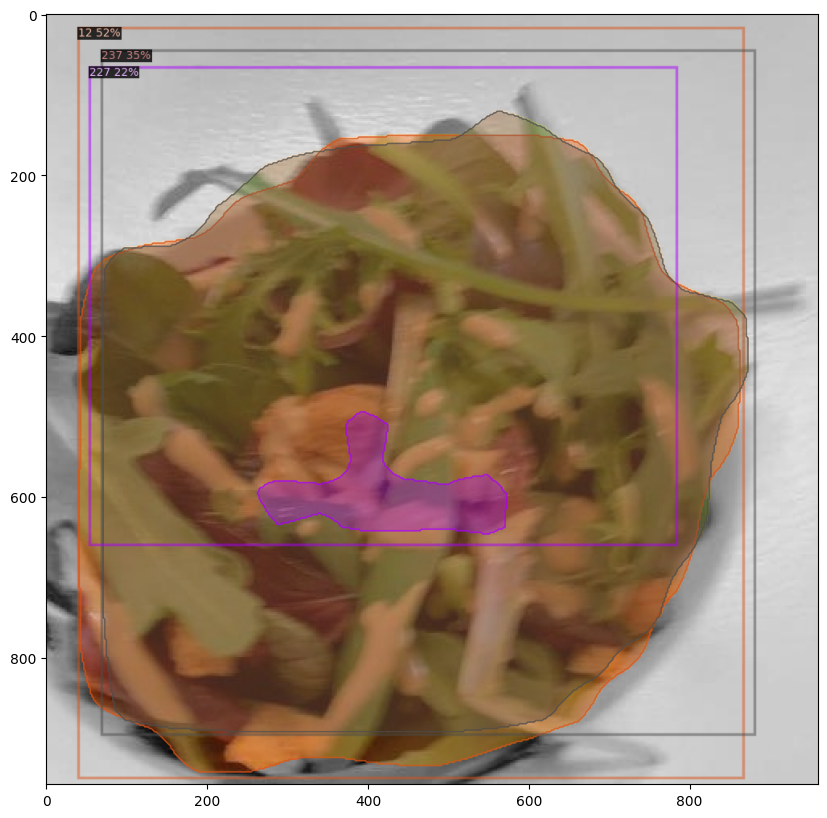

In [33]:
val_metadata = MetadataCatalog.get("val_dataset")

#sample image 
image_id = '020299'
im = cv2.imread(f"data/val/images/{image_id}.jpg")

outputs = predictor(im)

v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata, 
                   scale=2,
                   instance_mode=ColorMode.IMAGE_BW
    )

out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# cv2_imshow(out.get_image()[:, :, ::-1])
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

In [15]:
#generate class category ids from detectron2 internal dictinary mappings
category_ids = sorted(train_coco.getCatIds())
categories = train_coco.loadCats(category_ids)

class_to_category = { int(class_id): int(category_id) for class_id, category_id in enumerate(category_ids) }

with open("class_to_category.json", "w") as fp:
  json.dump(class_to_category, fp)

In [16]:
#setting the paths and threshold
test_images_dir = "data/test/images"
output_filepath = "R101_C4/freeze6/predictions_detectron2_freeze6.json"

#path of trained model
model_path = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

#threshold
threshold = 0.1

In [17]:
class_to_category = {}
with open("class_to_category.json") as fp:
    class_to_category = json.load(fp)

In [18]:
import importlib


def run():
    model_name = "model_zoo"
    model = importlib.import_module(f"detectron2.{model_name}")

    #set the config parameters, including the architecture which was previously used
    cfg = get_cfg()
    cfg.merge_from_file(model.get_config_file(MODEL_ARCH))
    cfg.MODEL.WEIGHTS = model_path

    #set the threshold 
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold   # set the testing threshold for this model
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 498

    cfg.MODEL.DEVICE = "cuda"
    predictor = DefaultPredictor(cfg)

    results = []
    for img_file in tqdm(os.listdir(test_images_dir)):
        filename = os.path.join(test_images_dir, img_file)
        img = cv2.imread(filename)
        prediction = predictor(img)

        instances = prediction["instances"]
        if len(instances) > 0:
            scores = instances.scores.tolist()
            classes = instances.pred_classes.tolist()
            bboxes = BoxMode.convert(
                instances.pred_boxes.tensor.cpu(),
                BoxMode.XYXY_ABS,
                BoxMode.XYWH_ABS,
            ).tolist()

            masks = []
            if instances.has("pred_masks"):
                for mask in instances.pred_masks.cpu():
                    _mask = mask_util.encode(np.array(mask[:, :, None], order="F", dtype="uint8"))[0]
                    _mask["counts"] = _mask["counts"].decode("utf-8")
                    masks.append(_mask)

            for idx in range(len(instances)):
                category_id = class_to_category[str(classes[idx])] # json converts int keys to str
                output = {
                    "image_id": int(img_file.split(".")[0]),
                    "category_id": category_id,
                    "bbox": bboxes[idx],
                    "score": scores[idx],
                }
                if len(masks) > 0:
                    output["segmentation"] = masks[idx]
                results.append(output)

        with open(output_filepath, "w") as fp:
            json.dump(results, fp)


#run the inference which generates predictions as json file
run()

  0%|          | 0/2819 [00:00<?, ?it/s]

In [ ]:
# dataset_dicts = get_microcontroller_dicts('Microcontroller Segmentation/test')
# for d in random.sample(dataset_dicts, 3):    
#     im = cv2.imread(d["file_name"])
#     outputs = predictor(im)
#     v = Visualizer(im[:, :, ::-1],
#                    metadata=microcontroller_metadata, 
#                    scale=0.8, 
#                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
#     )
#     v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#     plt.figure(figsize = (14, 10))
#     plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
#     plt.show()

In [2]:

# !pip install cython pyyaml==5.1
# !pip install -U pycocotools

# import torch
# TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
# CUDA_VERSION = torch.__version__.split("+")[-1]
# print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# # Install detectron2 that matches the above pytorch version
# # See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# # If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
# #don't forget to restart the runtime

torch:  1.8 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.8/index.html


In [2]:

# !pip install cython pyyaml==5.1
# !pip install -U pycocotools

# import torch
# TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
# CUDA_VERSION = torch.__version__.split("+")[-1]
# print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# # Install detectron2 that matches the above pytorch version
# # See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# # If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
# #don't forget to restart the runtime

torch:  1.8 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.8/index.html


In [32]:
# # List dataset for this challenge
# !aicrowd dataset list -c food-recognition-benchmark-2022

# # Download dataset
# !aicrowd dataset download -c food-recognition-benchmark-2022

                          Datasets for challenge #962                           
┌───┬───────────────────────────────┬───────────────────────────────┬──────────┐
│ # │ Title                         │ Description                   │     Size │
├───┼───────────────────────────────┼───────────────────────────────┼──────────┤
│ 0 │ random_prediction.json        │ Random prediction for Quick   │  4.36 MB │
│   │                               │ Submission into Round 2       │          │
│ 1 │ [Round 1]                     │ [Public] Testing Dataset      │     197M │
│   │ public_test_release_2.0.tar.… │ (contains 3000 images and 498 │          │
│   │                               │ categories, without           │          │
│   │                               │ annotations)                  │          │
│ 2 │ [Round 1]                     │ Training Dataset (contains    │   2.14GB │
│   │ public_training_set_release_… │ 39962 images and 498          │          │
│   │                       

public_training_set_release_2.1.tar.gz:   0%| | 10.5M/3.12G [00:02<10:00, 5.18MB

public_training_set_release_2.0.tar.gz:   8%| | 175M/2.30G [00:12<01:59, 17.8MB/


public_training_set_release_2.1.tar.gz:   0%| | 13.6M/3.12G [00:02<06:47, 7.62MB

public_training_set_release_2.0.tar.gz:   8%| | 177M/2.30G [00:13<02:09, 16.4MB/

public_test_release_2.1.tar.gz:  35%|██▍    | 58.7M/166M [00:11<00:14, 7.61MB/s]

public_test_release_2.1.tar.gz:  39%|██▋    | 65.0M/166M [00:11<00:08, 11.6MB/s]

public_test_release_2.1.tar.gz:  40%|██▊    | 67.1M/166M [00:11<00:09, 10.3MB/s]

public_test_release_2.1.tar.gz:  42%|██▉    | 70.3M/166M [00:12<00:07, 12.4MB/s]

public_training_set_release_2.0.tar.gz:   8%| | 192M/2.30G [00:14<02:20, 15.0MB/


public_test_release_2.1.tar.gz:  44%|███    | 73.4M/166M [00:12<00:06, 14.2MB/s]

public_training_set_release_2.0.tar.gz:   8%| | 195M/2.30G [00:14<02:12, 15.8MB/


public_training_set_release_2.1.tar.gz:   1%| | 18.9M/3.12G [00:03<09:41, 5.33MB

public_traini

public_training_set_release_2.1.tar.gz:   5%| | 143M/3.12G [00:23<08:48, 5.63MB/

public_training_set_release_2.0.tar.gz:  21%|▏| 482M/2.30G [00:34<02:19, 13.0MB/

public_training_set_release_2.0.tar.gz:  21%|▏| 485M/2.30G [00:34<02:08, 14.1MB/


public_training_set_release_2.1.tar.gz:   5%| | 145M/3.12G [00:23<08:27, 5.86MB/


public_training_set_release_2.1.tar.gz:   5%| | 148M/3.12G [00:24<06:23, 7.74MB/

public_training_set_release_2.0.tar.gz:  21%|▏| 489M/2.30G [00:34<02:01, 15.0MB/

public_training_set_release_2.0.tar.gz:  21%|▏| 491M/2.30G [00:34<02:02, 14.8MB/


public_training_set_release_2.1.tar.gz:   5%| | 151M/3.12G [00:24<06:34, 7.52MB/

public_training_set_release_2.0.tar.gz:  21%|▏| 493M/2.30G [00:35<02:41, 11.2MB/


public_training_set_release_2.1.tar.gz:   5%| | 153M/3.12G [00:24<05:42, 8.67MB/

public_training_set_release_2.0.tar.gz:  22%|▏| 496M/2.30G [00:35<02:20, 12.8MB/


public_training_set_release_2.1.tar.gz:   5%| | 156M/3.12G [00:24<04:33, 10.8MB/

public_trai

public_training_set_release_2.1.tar.gz:   7%| | 229M/3.12G [00:35<05:52, 8.20MB/


public_training_set_release_2.1.tar.gz:   7%| | 232M/3.12G [00:35<04:39, 10.3MB/

public_training_set_release_2.0.tar.gz:  28%|▎| 652M/2.30G [00:46<01:38, 16.8MB/

public_training_set_release_2.0.tar.gz:  28%|▎| 654M/2.30G [00:46<01:43, 15.9MB/

public_training_set_release_2.0.tar.gz:  29%|▎| 657M/2.30G [00:46<01:43, 15.8MB/


public_training_set_release_2.1.tar.gz:   8%| | 235M/3.12G [00:35<05:00, 9.61MB/


public_training_set_release_2.1.tar.gz:   8%| | 237M/3.12G [00:35<04:25, 10.9MB/

public_training_set_release_2.0.tar.gz:  29%|▎| 661M/2.30G [00:46<01:39, 16.5MB/


public_training_set_release_2.1.tar.gz:   8%| | 240M/3.12G [00:36<03:41, 13.0MB/

public_training_set_release_2.0.tar.gz:  29%|▎| 664M/2.30G [00:46<01:36, 16.9MB/

public_training_set_release_2.0.tar.gz:  29%|▎| 667M/2.30G [00:47<01:50, 14.8MB/

public_training_set_release_2.0.tar.gz:  29%|▎| 670M/2.30G [00:47<01:43, 15.7MB/

public_train

public_training_set_release_2.0.tar.gz:  42%|▍| 976M/2.30G [01:08<01:25, 15.5MB/

public_training_set_release_2.0.tar.gz:  43%|▍| 979M/2.30G [01:08<01:22, 16.1MB/


public_training_set_release_2.1.tar.gz:  13%|▏| 405M/3.12G [00:58<06:40, 6.78MB/

public_training_set_release_2.0.tar.gz:  43%|▍| 983M/2.30G [01:09<01:19, 16.6MB/


public_training_set_release_2.1.tar.gz:  13%|▏| 408M/3.12G [00:58<05:08, 8.79MB/

public_training_set_release_2.0.tar.gz:  43%|▍| 986M/2.30G [01:09<01:18, 16.8MB/

public_training_set_release_2.0.tar.gz:  43%|▍| 989M/2.30G [01:09<01:17, 17.0MB/

public_training_set_release_2.0.tar.gz:  43%|▍| 992M/2.30G [01:09<01:16, 17.0MB/

public_training_set_release_2.0.tar.gz:  43%|▍| 995M/2.30G [01:09<01:15, 17.3MB/

public_training_set_release_2.0.tar.gz:  43%|▍| 998M/2.30G [01:09<01:15, 17.2MB/


public_training_set_release_2.1.tar.gz:  13%|▏| 411M/3.12G [00:59<08:00, 5.64MB/

public_training_set_release_2.0.tar.gz:  44%|▍| 1.00G/2.30G [01:10<01:14, 17.4MB


public_train

public_training_set_release_2.1.tar.gz:  16%|▏| 505M/3.12G [01:09<04:10, 10.4MB/

public_training_set_release_2.0.tar.gz:  50%|▍| 1.14G/2.30G [01:19<01:10, 16.5MB


public_training_set_release_2.1.tar.gz:  16%|▏| 509M/3.12G [01:09<03:27, 12.6MB/

public_training_set_release_2.0.tar.gz:  50%|▍| 1.14G/2.30G [01:20<01:09, 16.6MB

public_training_set_release_2.0.tar.gz:  50%|▍| 1.14G/2.30G [01:20<01:12, 16.0MB

public_training_set_release_2.0.tar.gz:  50%|▍| 1.15G/2.30G [01:20<01:12, 15.8MB

public_training_set_release_2.0.tar.gz:  50%|▍| 1.15G/2.30G [01:20<01:08, 16.8MB

public_training_set_release_2.0.tar.gz:  50%|▌| 1.15G/2.30G [01:20<01:06, 17.4MB


public_training_set_release_2.1.tar.gz:  16%|▏| 512M/3.12G [01:09<05:11, 8.37MB/

public_training_set_release_2.0.tar.gz:  50%|▌| 1.15G/2.30G [01:20<01:07, 16.9MB


public_training_set_release_2.1.tar.gz:  16%|▏| 514M/3.12G [01:10<04:36, 9.43MB/

public_training_set_release_2.0.tar.gz:  50%|▌| 1.15G/2.30G [01:20<01:13, 15.6MB


public_train

public_training_set_release_2.1.tar.gz:  22%|▏| 688M/3.12G [01:29<04:04, 9.94MB/

public_training_set_release_2.0.tar.gz:  63%|▋| 1.44G/2.30G [01:40<00:50, 16.8MB


public_training_set_release_2.1.tar.gz:  22%|▏| 690M/3.12G [01:29<03:55, 10.3MB/

public_training_set_release_2.0.tar.gz:  63%|▋| 1.44G/2.30G [01:40<00:51, 16.5MB


public_training_set_release_2.1.tar.gz:  22%|▏| 693M/3.12G [01:30<03:14, 12.5MB/

public_training_set_release_2.0.tar.gz:  63%|▋| 1.45G/2.30G [01:40<00:50, 16.9MB


public_training_set_release_2.1.tar.gz:  22%|▏| 696M/3.12G [01:30<03:11, 12.6MB/

public_training_set_release_2.0.tar.gz:  63%|▋| 1.45G/2.30G [01:41<00:49, 17.0MB


public_training_set_release_2.1.tar.gz:  22%|▏| 699M/3.12G [01:30<02:46, 14.5MB/

public_training_set_release_2.0.tar.gz:  63%|▋| 1.45G/2.30G [01:41<00:48, 17.3MB


public_training_set_release_2.1.tar.gz:  23%|▏| 703M/3.12G [01:30<02:30, 16.0MB/

public_training_set_release_2.0.tar.gz:  63%|▋| 1.46G/2.30G [01:41<00:48, 17.5MB

public_trai

public_training_set_release_2.1.tar.gz:  29%|▎| 894M/3.12G [01:51<03:13, 11.5MB/

public_training_set_release_2.0.tar.gz:  75%|▊| 1.73G/2.30G [02:01<00:34, 16.6MB


public_training_set_release_2.1.tar.gz:  29%|▎| 898M/3.12G [01:51<02:54, 12.7MB/


public_training_set_release_2.1.tar.gz:  29%|▎| 900M/3.12G [01:51<02:52, 12.8MB/

public_training_set_release_2.0.tar.gz:  75%|▊| 1.74G/2.30G [02:02<00:36, 15.5MB


public_training_set_release_2.1.tar.gz:  29%|▎| 903M/3.12G [01:51<02:29, 14.8MB/

public_training_set_release_2.0.tar.gz:  76%|▊| 1.74G/2.30G [02:02<00:34, 16.1MB

public_training_set_release_2.0.tar.gz:  76%|▊| 1.74G/2.30G [02:02<00:33, 16.7MB


public_training_set_release_2.1.tar.gz:  29%|▎| 906M/3.12G [01:51<03:07, 11.8MB/


public_training_set_release_2.1.tar.gz:  29%|▎| 908M/3.12G [01:52<02:56, 12.5MB/


public_training_set_release_2.1.tar.gz:  29%|▎| 911M/3.12G [01:52<02:31, 14.5MB/


public_training_set_release_2.1.tar.gz:  29%|▎| 914M/3.12G [01:52<03:12, 11.4MB/


public_t

public_training_set_release_2.0.tar.gz:  88%|▉| 2.02G/2.30G [02:23<00:39, 7.09MB


public_training_set_release_2.1.tar.gz:  36%|▎| 1.11G/3.12G [02:12<04:57, 6.76MB

public_training_set_release_2.0.tar.gz:  88%|▉| 2.02G/2.30G [02:23<00:31, 8.80MB


public_training_set_release_2.1.tar.gz:  36%|▎| 1.11G/3.12G [02:12<03:47, 8.81MB

public_training_set_release_2.0.tar.gz:  88%|▉| 2.02G/2.30G [02:23<00:26, 10.5MB


public_training_set_release_2.1.tar.gz:  36%|▎| 1.12G/3.12G [02:13<03:35, 9.31MB

public_training_set_release_2.0.tar.gz:  88%|▉| 2.03G/2.30G [02:23<00:22, 12.2MB


public_training_set_release_2.1.tar.gz:  36%|▎| 1.12G/3.12G [02:13<03:16, 10.2MB

public_training_set_release_2.0.tar.gz:  88%|▉| 2.03G/2.30G [02:24<00:20, 13.3MB


public_training_set_release_2.1.tar.gz:  36%|▎| 1.12G/3.12G [02:13<02:41, 12.4MB

public_training_set_release_2.0.tar.gz:  88%|▉| 2.03G/2.30G [02:24<00:18, 14.2MB

public_training_set_release_2.0.tar.gz:  89%|▉| 2.04G/2.30G [02:24<00:17, 14.7MB

public_trai

public_training_set_release_2.1.tar.gz:  43%|▍| 1.33G/3.12G [02:38<04:06, 7.24MB


public_training_set_release_2.1.tar.gz:  43%|▍| 1.34G/3.12G [02:38<04:10, 7.13MB


public_training_set_release_2.1.tar.gz:  43%|▍| 1.34G/3.12G [02:38<03:13, 9.18MB


public_training_set_release_2.1.tar.gz:  43%|▍| 1.34G/3.12G [02:39<03:56, 7.52MB


public_training_set_release_2.1.tar.gz:  43%|▍| 1.34G/3.12G [02:39<03:28, 8.52MB


public_training_set_release_2.1.tar.gz:  43%|▍| 1.35G/3.12G [02:39<02:45, 10.7MB


public_training_set_release_2.1.tar.gz:  43%|▍| 1.35G/3.12G [02:40<04:32, 6.48MB


public_training_set_release_2.1.tar.gz:  43%|▍| 1.35G/3.12G [02:40<04:17, 6.85MB


public_training_set_release_2.1.tar.gz:  43%|▍| 1.36G/3.12G [02:41<03:19, 8.82MB


public_training_set_release_2.1.tar.gz:  44%|▍| 1.36G/3.12G [02:41<03:17, 8.89MB


public_training_set_release_2.1.tar.gz:  44%|▍| 1.36G/3.12G [02:41<02:56, 9.96MB


public_training_set_release_2.1.tar.gz:  44%|▍| 1.36G/3.12G [02:41<02:25, 12.1MB


publ

public_training_set_release_2.1.tar.gz:  59%|▌| 1.83G/3.12G [03:32<02:31, 8.49MB


public_training_set_release_2.1.tar.gz:  59%|▌| 1.83G/3.12G [03:32<02:14, 9.54MB


public_training_set_release_2.1.tar.gz:  59%|▌| 1.83G/3.12G [03:32<01:49, 11.7MB


public_training_set_release_2.1.tar.gz:  59%|▌| 1.84G/3.12G [03:34<04:40, 4.57MB


public_training_set_release_2.1.tar.gz:  59%|▌| 1.84G/3.12G [03:34<03:30, 6.08MB


public_training_set_release_2.1.tar.gz:  59%|▌| 1.84G/3.12G [03:34<02:50, 7.48MB


public_training_set_release_2.1.tar.gz:  59%|▌| 1.85G/3.12G [03:35<04:44, 4.47MB


public_training_set_release_2.1.tar.gz:  59%|▌| 1.85G/3.12G [03:35<03:53, 5.45MB


public_training_set_release_2.1.tar.gz:  59%|▌| 1.85G/3.12G [03:35<02:53, 7.33MB


public_training_set_release_2.1.tar.gz:  59%|▌| 1.85G/3.12G [03:36<02:41, 7.83MB


public_training_set_release_2.1.tar.gz:  60%|▌| 1.86G/3.12G [03:36<02:26, 8.62MB


public_training_set_release_2.1.tar.gz:  60%|▌| 1.86G/3.12G [03:36<01:56, 10.8MB


publ

public_training_set_release_2.1.tar.gz:  74%|▋| 2.32G/3.12G [04:20<01:22, 9.70MB


public_training_set_release_2.1.tar.gz:  74%|▋| 2.32G/3.12G [04:21<01:12, 11.1MB


public_training_set_release_2.1.tar.gz:  74%|▋| 2.32G/3.12G [04:21<01:00, 13.2MB


public_training_set_release_2.1.tar.gz:  75%|▋| 2.32G/3.12G [04:21<01:10, 11.2MB


public_training_set_release_2.1.tar.gz:  75%|▋| 2.33G/3.12G [04:21<01:06, 11.9MB


public_training_set_release_2.1.tar.gz:  75%|▋| 2.33G/3.12G [04:21<00:56, 13.9MB


public_training_set_release_2.1.tar.gz:  75%|▋| 2.33G/3.12G [04:22<01:03, 12.3MB


public_training_set_release_2.1.tar.gz:  75%|▋| 2.33G/3.12G [04:22<01:02, 12.5MB


public_training_set_release_2.1.tar.gz:  75%|▋| 2.34G/3.12G [04:22<00:54, 14.2MB


public_training_set_release_2.1.tar.gz:  75%|▊| 2.34G/3.12G [04:22<01:01, 12.7MB


public_training_set_release_2.1.tar.gz:  75%|▊| 2.34G/3.12G [04:22<00:57, 13.4MB


public_training_set_release_2.1.tar.gz:  75%|▊| 2.35G/3.12G [04:23<00:50, 15.3MB


publ

public_training_set_release_2.1.tar.gz:  90%|▉| 2.80G/3.12G [05:06<00:26, 12.1MB


public_training_set_release_2.1.tar.gz:  90%|▉| 2.80G/3.12G [05:06<00:25, 12.5MB


public_training_set_release_2.1.tar.gz:  90%|▉| 2.81G/3.12G [05:06<00:21, 14.5MB


public_training_set_release_2.1.tar.gz:  90%|▉| 2.81G/3.12G [05:07<00:31, 9.81MB


public_training_set_release_2.1.tar.gz:  90%|▉| 2.81G/3.12G [05:07<00:33, 9.09MB


public_training_set_release_2.1.tar.gz:  90%|▉| 2.82G/3.12G [05:07<00:26, 11.3MB


public_training_set_release_2.1.tar.gz:  90%|▉| 2.82G/3.12G [05:08<00:27, 10.9MB


public_training_set_release_2.1.tar.gz:  90%|▉| 2.82G/3.12G [05:08<00:27, 10.9MB


public_training_set_release_2.1.tar.gz:  91%|▉| 2.82G/3.12G [05:08<00:22, 13.0MB


public_training_set_release_2.1.tar.gz:  91%|▉| 2.83G/3.12G [05:09<00:28, 10.3MB


public_training_set_release_2.1.tar.gz:  91%|▉| 2.83G/3.12G [05:09<00:25, 11.3MB


public_training_set_release_2.1.tar.gz:  91%|▉| 2.83G/3.12G [05:09<00:21, 13.5MB


publ

In [33]:
# !mkdir -p data/ data/train data/val data/test
# ls

In [2]:
# !cp *test* data/test && cd data/test && echo "Extracting test dataset" && tar -xvf public_test_release_2.1.tar.gz > /dev/null
# !cp *val* data/val && cd data/val && echo "Extracting val dataset" &&  tar -xvf public_validation_set_release_2.1.tar.gz > /dev/null
# !cp *train* data/train && cd data/train && echo "Extracting train dataset" &&  tar -xvf public_training_set_release_2.1.tar.gz > /dev/null

Extracting test dataset
Extracting val dataset
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.lastuseddate#PS'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.lastuseddate#PS'
Extracting train dataset
